#### Master of Data Science (Digital Humanities), Durham University
#### Final Project Notebooks

### DATA40345 Data Science Research Project

#### NLP Esquire: A Data-Driven Approach to the Analysis and Categorisation of the Judgments of the United Kingdom Supreme Court

## Notebook 2: Data Extraction and Data Analysis


In [1]:
#importing required libraries
import glob
import os
import regex as re
import pandas as pd
import numpy as np
import datetime

#libraries for visualisations and tables
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
#loading the data to a pandas df
#the following code opens the .txt files, cleans the data, and creates a clean df

directory = "./Dataset_UKSC_Final_txt/"

#empty lists to store cleaned text and filenames 
clean_text = []
file_names = []

#loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        #open .txt file as a string
        with open(os.path.join(directory, filename), "r", encoding="utf-8") as file:
            data = file.read()

        #convert to bytes with utf-8 encoding
        #convert to ascii encoding and discard alien characters
        data_clean = data.encode("utf-8").decode("ascii", "ignore")
        
        #add the cleaned text to the list
        clean_text.append(data)
        #clean file name (remove .txt)
        filename = filename[:-4]
        #add the filename to the list
        file_names.append(filename)

#create df with title and cleaned text as columns
UKSC_df = pd.DataFrame({"title": file_names, "text": clean_text})

In [4]:
UKSC_df.head(5)

,title,text
0,uksc-2009-0015-judgment-01,Hilary Term \n[2010] UKSC 1 \n\nJUDGMENT \n\nA...
1,uksc-2009-0019-judgment,Michaelmas Term \n[2009] UKSC 5 \nOn appeal fr...
2,uksc-2009-0020-judgment,Michaelmas Term \n[2009] UKSC 12 \nOn appeal f...
3,uksc-2009-0022-judgment,Easter Term \n[2011] UKSC 23 \nOn appeal from:...
4,uksc-2009-0031-judgment,Michaelmas Term \n[2010] UKSC 42 \nOn appeal f...


In [5]:
UKSC_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   918 non-null    object
 1   text    918 non-null    object
dtypes: object(2)
memory usage: 14.5+ KB


In [6]:
print("The dataset has", UKSC_df.shape[0], "rows and", UKSC_df.shape[1], "columns")
print()
print("The dataset has", UKSC_df.isna().sum()[0], "empty titles and", UKSC_df.isna().sum()[1], "empty judgment texts")

The dataset has 918 rows and 2 columns

The dataset has 0 empty titles and 0 empty judgment texts


In [7]:
#check ftitle_dup = UKSC or duplicates
title_dup = UKSC_df["title"].duplicated()
unique_titles = UKSC_df["title"].unique()
print("There are", len(unique_titles), "case numbers in the dataset")

print()

text_dup = UKSC_df["title"].duplicated()
unique_texts = UKSC_df["title"].unique()
print("There are", len(unique_texts), "judgment texts in the dataset")


There are 918 case numbers in the dataset

There are 918 judgment texts in the dataset


In [8]:
##converting the columns to string
UKSC_df['title'] = UKSC_df['title'].astype(str)
UKSC_df['text'] = UKSC_df['text'].astype(str)

In [9]:
#save the df for future use
UKSC_df.to_csv("UKSC Judgments.csv", encoding="utf-8", index=False) #removes the index column

### Extracting Data using NLP - Regex

Extracting the case number of the lower court case that was appealed.

Judgments include the case number that was appealed in two primary ways:

On appeal from: [2008] EWCA 1552
On appeals from: [2010] EWCA Civ 895

First, regex was used to extract "On appeal from" which resulted in 77 NaN values. Next, it was amended to extract "On appeals from" using "s?" after "appeal". This reduced NaN values to 58. Thereafter, the regex was amended to also extract citations where (a) there is more than one case citation, and (b) where there are spaces and line breaks between the citations. This reduced NaN values to 28.

It is noted, however, that some judgments are not actually appeals, but direct referrals to the UKSC. In these cases, the judgment would not have a case number from which it was appealed. Further, some judgments simply do not include the case number that was appealed. 

In [27]:
#extracting the case number of the lower court case that was appealed to the UKSC
UKSC_df["Judgment Appealed"] = UKSC_df["text"].str.extract(r'On appeals? from:\s*(.*?)(?:\s*JUDGMENT|$)')
print("The dataset has", UKSC_df.isna().sum()[2], "empty (NaN values) case numbers appealed. This could be due to (1) cases being directly referred to the UKSC (and not appealed), and (2) the case which is being appealed not being mentioned in the judgment.")
UKSC_df.head(5)

The dataset has 58 empty (NaN values) case numbers appealed. This could be due to (1) cases being directly referred to the UKSC (and not appealed), and (2) the case which is being appealed not being mentioned in the judgment.


,title,text,Judgment Appealed
0,uksc-2009-0015-judgment-01,Hilary Term \n[2010] UKSC 1 \n\nJUDGMENT \n\nA...,NaN
1,uksc-2009-0019-judgment,Michaelmas Term \n[2009] UKSC 5 \nOn appeal fr...,[2009] EWCA Civ 545
2,uksc-2009-0020-judgment,Michaelmas Term \n[2009] UKSC 12 \nOn appeal f...,[2009] EWCA Civ 24
3,uksc-2009-0022-judgment,Easter Term \n[2011] UKSC 23 \nOn appeal from:...,[2008] EWCA Civ 1204
4,uksc-2009-0031-judgment,Michaelmas Term \n[2010] UKSC 42 \nOn appeal f...,2009 EWCA Civ 649


Extracting the year the case was appealed to the UKSC delivered from the title.

In [28]:
UKSC_df["year of appeal"] = UKSC_df["title"].str.extract(r'-(\d+)-') #use regex to divide string based on "-" and extract the year
print("The dataset has", UKSC_df.isna().sum()[3], "empty (NaN values) in year in which the judgment was delivered")
UKSC_df.head(5)

The dataset has 0 empty (NaN values) in year in which the judgment was delivered


,title,text,Judgment Appealed,year of appeal
0,uksc-2009-0015-judgment-01,Hilary Term \n[2010] UKSC 1 \n\nJUDGMENT \n\nA...,NaN,2009
1,uksc-2009-0019-judgment,Michaelmas Term \n[2009] UKSC 5 \nOn appeal fr...,[2009] EWCA Civ 545,2009
2,uksc-2009-0020-judgment,Michaelmas Term \n[2009] UKSC 12 \nOn appeal f...,[2009] EWCA Civ 24,2009
3,uksc-2009-0022-judgment,Easter Term \n[2011] UKSC 23 \nOn appeal from:...,[2008] EWCA Civ 1204,2009
4,uksc-2009-0031-judgment,Michaelmas Term \n[2010] UKSC 42 \nOn appeal f...,2009 EWCA Civ 649,2009


Extract the Term in which the judgment was delivered

In [29]:
UKSC_df["Term"] = UKSC_df["text"].str.extract(r'(Michaelmas|Hilary|Easter|Trinity) Term')
print("The dataset has", UKSC_df.isna().sum()[4], "empty (NaN values) in the term in which the judgment was delivered")
UKSC_df.head(5)

The dataset has 16 empty (NaN values) in the term in which the judgment was delivered


,title,text,Judgment Appealed,year of appeal,Term
0,uksc-2009-0015-judgment-01,Hilary Term \n[2010] UKSC 1 \n\nJUDGMENT \n\nA...,NaN,2009,Hilary
1,uksc-2009-0019-judgment,Michaelmas Term \n[2009] UKSC 5 \nOn appeal fr...,[2009] EWCA Civ 545,2009,Michaelmas
2,uksc-2009-0020-judgment,Michaelmas Term \n[2009] UKSC 12 \nOn appeal f...,[2009] EWCA Civ 24,2009,Michaelmas
3,uksc-2009-0022-judgment,Easter Term \n[2011] UKSC 23 \nOn appeal from:...,[2008] EWCA Civ 1204,2009,Easter
4,uksc-2009-0031-judgment,Michaelmas Term \n[2010] UKSC 42 \nOn appeal f...,2009 EWCA Civ 649,2009,Michaelmas


Extract the names of the judges

In [30]:
UKSC_df["Judges"] = UKSC_df["text"].str.extract(r'before\s+([\s\S]*?)\s+JUDGMENT GIVEN ON')
print("There are", UKSC_df.isna().sum()[5], "empty (NaN values) in Judges column.")
UKSC_df.head(5)

There are 3 empty (NaN values) in Judges column.


,title,text,Judgment Appealed,year of appeal,Term,Judges
0,uksc-2009-0015-judgment-01,Hilary Term \n[2010] UKSC 1 \n\nJUDGMENT \n\nA...,NaN,2009,Hilary,"Lord Phillips, President \nLord Hope, Deputy P..."
1,uksc-2009-0019-judgment,Michaelmas Term \n[2009] UKSC 5 \nOn appeal fr...,[2009] EWCA Civ 545,2009,Michaelmas,"Lord Hope, Deputy President \nLady Hale \nLord..."
2,uksc-2009-0020-judgment,Michaelmas Term \n[2009] UKSC 12 \nOn appeal f...,[2009] EWCA Civ 24,2009,Michaelmas,"Lord Phillips, President \nLord Hope, Deputy P..."
3,uksc-2009-0022-judgment,Easter Term \n[2011] UKSC 23 \nOn appeal from:...,[2008] EWCA Civ 1204,2009,Easter,"Lord Hope, Deputy President \nLord Rodger \nLa..."
4,uksc-2009-0031-judgment,Michaelmas Term \n[2010] UKSC 42 \nOn appeal f...,2009 EWCA Civ 649,2009,Michaelmas,"Lord Phillips, President \nLord Hope, Deputy P..."


Extract Judgment Date

In [31]:
UKSC_df["Date (judgment)"] = UKSC_df["text"].str.extract(r'JUDGMENT GIVEN ON\s+([\s\S]*?)\s+Heard')
print("There are", UKSC_df.isna().sum()[6], "empty (NaN values) rows in date of judgment.")
UKSC_df.tail(5)

There are 5 empty (NaN values) rows in date of judgment.


,title,text,Judgment Appealed,year of appeal,Term,Judges,Date (judgment)
913,uksc-2022-0052-judgment,Hilary Term \n[2023] UKSC 13 \nOn appeal from:...,[2022] EWCA Civ 4,2022,Hilary,"Lord Hodge, Deputy President \nLord Kitchin \n...",5 April 2023
914,uksc-2022-0056-judgment,Easter Term \n[2023] UKSC 14 \nOn appeal from:...,[2021] NICA 67,2022,Easter,"Lord Reed, President \nLord Sales \nLord Hambl...",19 April 2023
915,uksc-2022-0077-judgment,Michaelmas Term \n[2022] UKSC 32 \n\nJUDGMENT ...,NaN,2022,Michaelmas,Lord Reed (President) \nLord Kitchin \nLord Bu...,7 December 2022
916,uksc-2022-0089-0093-judgment,Hilary Term \n[2023] UKSC 5 \nOn appeal from: ...,[2022] NICA 15,2022,Hilary,"Lord Reed, President \nLord Hodge, Deputy Pres...",8 February 2023
917,uksc-2022-0098-judgment,Michaelmas Term \n[2022] UKSC 31 \n\nJUDGMENT ...,NaN,2022,Michaelmas,"Lord Reed, President \nLord Lloyd-Jones \nLord...",23 November 2022


Extract the dates of the hearings

In [32]:
UKSC_df["Hearings"] = UKSC_df["text"].str.extract(r'Heard on\s+([\s\S]*?)\s+Appellant')
print("There are", UKSC_df.isna().sum()[7], "empty (NaN values) rows in Hearings.")
UKSC_df.head(5)

There are 19 empty (NaN values) rows in Hearings.


,title,text,Judgment Appealed,year of appeal,Term,Judges,Date (judgment),Hearings
0,uksc-2009-0015-judgment-01,Hilary Term \n[2010] UKSC 1 \n\nJUDGMENT \n\nA...,NaN,2009,Hilary,"Lord Phillips, President \nLord Hope, Deputy P...",27 January 2010,5 and 22 October 2009 \n\n \n \n \n \n \n \n ...
1,uksc-2009-0019-judgment,Michaelmas Term \n[2009] UKSC 5 \nOn appeal fr...,[2009] EWCA Civ 545,2009,Michaelmas,"Lord Hope, Deputy President \nLady Hale \nLord...",19 November 2009,14 October 2009
2,uksc-2009-0020-judgment,Michaelmas Term \n[2009] UKSC 12 \nOn appeal f...,[2009] EWCA Civ 24,2009,Michaelmas,"Lord Phillips, President \nLord Hope, Deputy P...",9 December 2009,19 and 20 October 2009
3,uksc-2009-0022-judgment,Easter Term \n[2011] UKSC 23 \nOn appeal from:...,[2008] EWCA Civ 1204,2009,Easter,"Lord Hope, Deputy President \nLord Rodger \nLa...",25 May 2011,10 and 11 February 2010 \n\n \n \n \n \n \n \n...
4,uksc-2009-0031-judgment,Michaelmas Term \n[2010] UKSC 42 \nOn appeal f...,2009 EWCA Civ 649,2009,Michaelmas,"Lord Phillips, President \nLord Hope, Deputy P...",20 October 2010,22 and 23 March 2010


Extract Names of the Parties

In [33]:
UKSC_df["Parties"] = UKSC_df["text"].str.extract(r'JUDGMENT\s+([\s\S]*?)\s+before')
print("There are", UKSC_df.isna().sum()[8], "empty (NaN values) rows in Parties.")
UKSC_df.head(4)

There are 0 empty (NaN values) rows in Parties.


,title,text,Judgment Appealed,year of appeal,Term,Judges,Date (judgment),Hearings,Parties
0,uksc-2009-0015-judgment-01,Hilary Term \n[2010] UKSC 1 \n\nJUDGMENT \n\nA...,NaN,2009,Hilary,"Lord Phillips, President \nLord Hope, Deputy P...",27 January 2010,5 and 22 October 2009 \n\n \n \n \n \n \n \n ...,Application by Guardian News and Media Ltd and...
1,uksc-2009-0019-judgment,Michaelmas Term \n[2009] UKSC 5 \nOn appeal fr...,[2009] EWCA Civ 545,2009,Michaelmas,"Lord Hope, Deputy President \nLady Hale \nLord...",19 November 2009,14 October 2009,In re B (A Child) (2009) (FC)
2,uksc-2009-0020-judgment,Michaelmas Term \n[2009] UKSC 12 \nOn appeal f...,[2009] EWCA Civ 24,2009,Michaelmas,"Lord Phillips, President \nLord Hope, Deputy P...",9 December 2009,19 and 20 October 2009,R (on the application of A) (Appellant) v B \n...
3,uksc-2009-0022-judgment,Easter Term \n[2011] UKSC 23 \nOn appeal from:...,[2008] EWCA Civ 1204,2009,Easter,"Lord Hope, Deputy President \nLord Rodger \nLa...",25 May 2011,10 and 11 February 2010 \n\n \n \n \n \n \n \n...,Shepherd Masimba Kambadzi (previously referred...


Extract the Case Citation Number

In [34]:
UKSC_df["Citation"] = UKSC_df["text"].str.extract(r'(\[\d{4}\] UKSC \d+)')
print("There are", UKSC_df.isna().sum()[9], "empty (NaN values) rows in Citation.")
UKSC_df.head(4)

There are 0 empty (NaN values) rows in Citation.


,title,text,Judgment Appealed,year of appeal,Term,Judges,Date (judgment),Hearings,Parties,Citation
0,uksc-2009-0015-judgment-01,Hilary Term \n[2010] UKSC 1 \n\nJUDGMENT \n\nA...,NaN,2009,Hilary,"Lord Phillips, President \nLord Hope, Deputy P...",27 January 2010,5 and 22 October 2009 \n\n \n \n \n \n \n \n ...,Application by Guardian News and Media Ltd and...,[2010] UKSC 1
1,uksc-2009-0019-judgment,Michaelmas Term \n[2009] UKSC 5 \nOn appeal fr...,[2009] EWCA Civ 545,2009,Michaelmas,"Lord Hope, Deputy President \nLady Hale \nLord...",19 November 2009,14 October 2009,In re B (A Child) (2009) (FC),[2009] UKSC 5
2,uksc-2009-0020-judgment,Michaelmas Term \n[2009] UKSC 12 \nOn appeal f...,[2009] EWCA Civ 24,2009,Michaelmas,"Lord Phillips, President \nLord Hope, Deputy P...",9 December 2009,19 and 20 October 2009,R (on the application of A) (Appellant) v B \n...,[2009] UKSC 12
3,uksc-2009-0022-judgment,Easter Term \n[2011] UKSC 23 \nOn appeal from:...,[2008] EWCA Civ 1204,2009,Easter,"Lord Hope, Deputy President \nLord Rodger \nLa...",25 May 2011,10 and 11 February 2010 \n\n \n \n \n \n \n \n...,Shepherd Masimba Kambadzi (previously referred...,[2011] UKSC 23


Extract the Year of the Judgment

In [35]:
UKSC_df["Year (judgment)"] = UKSC_df["Citation"].str.extract(r'(\d{4})')
print("There are", UKSC_df.isna().sum()[10], "empty (NaN values) rows in Year of Judgment.")
UKSC_df.head(4)

There are 0 empty (NaN values) rows in Year of Judgment.


,title,text,Judgment Appealed,year of appeal,Term,Judges,Date (judgment),Hearings,Parties,Citation,Year (judgment)
0,uksc-2009-0015-judgment-01,Hilary Term \n[2010] UKSC 1 \n\nJUDGMENT \n\nA...,NaN,2009,Hilary,"Lord Phillips, President \nLord Hope, Deputy P...",27 January 2010,5 and 22 October 2009 \n\n \n \n \n \n \n \n ...,Application by Guardian News and Media Ltd and...,[2010] UKSC 1,2010
1,uksc-2009-0019-judgment,Michaelmas Term \n[2009] UKSC 5 \nOn appeal fr...,[2009] EWCA Civ 545,2009,Michaelmas,"Lord Hope, Deputy President \nLady Hale \nLord...",19 November 2009,14 October 2009,In re B (A Child) (2009) (FC),[2009] UKSC 5,2009
2,uksc-2009-0020-judgment,Michaelmas Term \n[2009] UKSC 12 \nOn appeal f...,[2009] EWCA Civ 24,2009,Michaelmas,"Lord Phillips, President \nLord Hope, Deputy P...",9 December 2009,19 and 20 October 2009,R (on the application of A) (Appellant) v B \n...,[2009] UKSC 12,2009
3,uksc-2009-0022-judgment,Easter Term \n[2011] UKSC 23 \nOn appeal from:...,[2008] EWCA Civ 1204,2009,Easter,"Lord Hope, Deputy President \nLord Rodger \nLa...",25 May 2011,10 and 11 February 2010 \n\n \n \n \n \n \n \n...,Shepherd Masimba Kambadzi (previously referred...,[2011] UKSC 23,2011


In [36]:
UKSC_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              918 non-null    object
 1   text               918 non-null    object
 2   Judgment Appealed  860 non-null    object
 3   year of appeal     918 non-null    object
 4   Term               902 non-null    object
 5   Judges             915 non-null    object
 6   Date (judgment)    913 non-null    object
 7   Hearings           899 non-null    object
 8   Parties            918 non-null    object
 9   Citation           918 non-null    object
 10  Year (judgment)    918 non-null    object
dtypes: object(11)
memory usage: 79.0+ KB


In [37]:
#cleaning line breaks
UKSC = UKSC_df
UKSC = UKSC.replace(r'\n',' ', regex=True)

In [39]:
UKSC.head(3)

,title,text,Judgment Appealed,year of appeal,Term,Judges,Date (judgment),Hearings,Parties,Citation,Year (judgment)
0,uksc-2009-0015-judgment-01,Hilary Term [2010] UKSC 1 JUDGMENT Applic...,NaN,2009,Hilary,"Lord Phillips, President Lord Hope, Deputy Pr...",27 January 2010,5 and 22 October 2009 ...,Application by Guardian News and Media Ltd and...,[2010] UKSC 1,2010
1,uksc-2009-0019-judgment,Michaelmas Term [2009] UKSC 5 On appeal from...,[2009] EWCA Civ 545,2009,Michaelmas,"Lord Hope, Deputy President Lady Hale Lord C...",19 November 2009,14 October 2009,In re B (A Child) (2009) (FC),[2009] UKSC 5,2009
2,uksc-2009-0020-judgment,Michaelmas Term [2009] UKSC 12 On appeal fro...,[2009] EWCA Civ 24,2009,Michaelmas,"Lord Phillips, President Lord Hope, Deputy Pr...",9 December 2009,19 and 20 October 2009,R (on the application of A) (Appellant) v B (...,[2009] UKSC 12,2009


In [41]:
UKSC_df2 = UKSC
UKSC_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              918 non-null    object
 1   text               918 non-null    object
 2   Judgment Appealed  860 non-null    object
 3   year of appeal     918 non-null    object
 4   Term               902 non-null    object
 5   Judges             915 non-null    object
 6   Date (judgment)    913 non-null    object
 7   Hearings           899 non-null    object
 8   Parties            918 non-null    object
 9   Citation           918 non-null    object
 10  Year (judgment)    918 non-null    object
dtypes: object(11)
memory usage: 79.0+ KB


### Decision-columns

The decision in each judgment is difficult to extract accurately. Therefore, to reduce error, a two-pronged approach is adopted: 

Press summaries available for each case from 2009-2023 were scraped. Press summaries have a clear section that says "JUDGMENT" which make it easier to accurately extract the correct decision. However, (1) not all press summaries uploaded have information, (2) press summaries are available in HTML only from 2021-2023, (3) press summaries from 2009-2000 are in PDF. 

Therefore (1) the HTML press summaries for years 2021-2023 were scraped, and (2) the PDF press summaries for years 2009-2020 were downloaded and converted to .txt files. First the data in these two need to be amalgamated.

In [44]:
#loading the data to a pandas df
#the following code opens the .txt files, cleans the data, and creates a clean df

directory = "./Dataset_UKSC-PressSum_PDFMiner/"

#empty lists to store cleaned text and filenames 
clean_text = []
file_names = []

#loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        #open .txt file as a string
        with open(os.path.join(directory, filename), "r", encoding="utf-8") as file:
            data = file.read()

        #convert to bytes with utf-8 encoding
        #convert to ascii encoding and discard alien characters
        data_clean = data.encode("utf-8").decode("ascii", "ignore")
        
        #add the cleaned text to the list
        clean_text.append(data)
        #clean file name (remove .txt)
        filename = filename[:-4]
        #add the filename to the list
        file_names.append(filename)

#create df with title and cleaned text as columns
UKSC_P = pd.DataFrame({"title": file_names, "text": clean_text})

In [45]:
UKSC_P.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   648 non-null    object
 1   text    648 non-null    object
dtypes: object(2)
memory usage: 10.2+ KB


In [46]:
#remove line breaks in text
UKSC_P["text"] = UKSC_P["text"].replace(r"\n", " ", regex=True)

In [47]:
UKSC_P.head(4)

,title,text
0,uksc-2009-0015-press-summary-01,PRESS SUMMARY 27 January 2010 Application ...
1,uksc-2009-0019-press-summary,19 November 2009 PRESS SUMMARY In GB v RJB...
2,uksc-2009-0020-press-summary,9 December 2009 PRESS SUMMARY R (on the ap...
3,uksc-2009-0022-press-summary,PRESS SUMMARY 25 May 2011 Shepherd Masimba...


In [48]:
print("The dataset has", UKSC_P.shape[0], "rows and", UKSC_P.shape[1], "columns")
print()
print("The dataset has", UKSC_P.isna().sum()[0], "empty titles and", UKSC_P.isna().sum()[1], "empty judgment texts")

The dataset has 648 rows and 2 columns

The dataset has 0 empty titles and 0 empty judgment texts


In [49]:
#check ftitle_dup = UKSC or duplicates
title_dup = UKSC_P["title"].duplicated()
unique_titles = UKSC_P["title"].unique()
print("There are", len(unique_titles), "case numbers in the dataset")

print()

text_dup = UKSC_P["title"].duplicated()
unique_texts = UKSC_P["title"].unique()
print("There are", len(unique_texts), "judgment texts in the dataset")

There are 648 case numbers in the dataset

There are 648 judgment texts in the dataset


In [50]:
UKSC_P = UKSC_P.drop_duplicates()
UKSC_P.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 0 to 647
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   648 non-null    object
 1   text    648 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [51]:
UKSC_P2123 = pd.read_csv("UKSC 2021-23 Decision Data.csv")
UKSC_P2123

,Case Ref,Decision
0,uksc-2021-0160,"Jointly, Lord Briggs, Lord Kitchin, Lord Burro..."
1,uksc-2020-0195,The Supreme Court unanimously allows the appea...
2,uksc-2020-0081,\r\nThe Supreme Court unanimously dismisses th...
3,uksc-2020-0029,The Supreme Court allows the appeals by the Ch...
4,uksc-2020-0029,The Supreme Court allows the appeals by the Ch...
5,uksc-2020-0029,The Supreme Court allows the appeals by the Ch...
6,uksc-2020-0019,The Supreme Court allows the appeals by the Ch...
7,uksc-2020-0019,The Supreme Court allows the appeals by the Ch...
8,uksc-2020-0028,The Supreme Court allows the appeals by the Ch...
9,uksc-2020-0028,The Supreme Court allows the appeals by the Ch...


In [52]:
print("The dataset has", UKSC_P2123.shape[0], "rows and", UKSC_P2123.shape[1], "columns")

The dataset has 149 rows and 2 columns


In [53]:
#there are several duplicates because multiple cases get amalgamated to one judgment.
#drop duplicates
UKSC_P2123 = UKSC_P2123.drop_duplicates()
UKSC_P2123.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 0 to 148
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Case Ref  133 non-null    object
 1   Decision  132 non-null    object
dtypes: object(2)
memory usage: 3.1+ KB


In [54]:
#rename column names (for merging later)
UKSC_P2123.rename(columns={"Case Ref": "title", "Decision": "Press_Decision"}, inplace=True)

#rename titles (for merging later)
UKSC_P2123["title"] = UKSC_P2123["title"] + "-judgment"

UKSC_P2123.head(3)

C:\Users\Sandani-PC\appdata\Local\Temp\ipykernel_20544\2994193828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UKSC_P2123.rename(columns={"Case Ref": "title", "Decision": "Press_Decision"}, inplace=True)
C:\Users\Sandani-PC\appdata\Local\Temp\ipykernel_20544\2994193828.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UKSC_P2123["title"] = UKSC_P2123["title"] + "-judgment"


,title,Press_Decision
0,uksc-2021-0160-judgment,"Jointly, Lord Briggs, Lord Kitchin, Lord Burro..."
1,uksc-2020-0195-judgment,The Supreme Court unanimously allows the appea...
2,uksc-2020-0081-judgment,\r\nThe Supreme Court unanimously dismisses th...


In [55]:
UKSC_P.info()
print()
UKSC_P2123.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 0 to 647
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   648 non-null    object
 1   text    648 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 0 to 148
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           133 non-null    object
 1   Press_Decision  132 non-null    object
dtypes: object(2)
memory usage: 3.1+ KB


In [56]:
#concatanate the two dfs together (ignore_index so that df has continued numbering in index)
ukscP = pd.concat([UKSC_P, UKSC_P2123], ignore_index=True)
ukscP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           781 non-null    object
 1   text            648 non-null    object
 2   Press_Decision  132 non-null    object
dtypes: object(3)
memory usage: 18.4+ KB


In [57]:
ukscP

,title,text,Press_Decision
0,uksc-2009-0015-press-summary-01,PRESS SUMMARY 27 January 2010 Application ...,NaN
1,uksc-2009-0019-press-summary,19 November 2009 PRESS SUMMARY In GB v RJB...,NaN
2,uksc-2009-0020-press-summary,9 December 2009 PRESS SUMMARY R (on the ap...,NaN
3,uksc-2009-0022-press-summary,PRESS SUMMARY 25 May 2011 Shepherd Masimba...,NaN
4,uksc-2009-0031-press-summary,20 October 2010 PRESS SUMMARY Radmacher (f...,NaN
5,uksc-2009-0032-press-summary,PRESS SUMMARY 28 July 2010 Star Energy Wea...,NaN
6,uksc-2009-0034-press-summary,10 March 2010 PRESS SUMMARY Agbaje (Respon...,NaN
7,uksc-2009-0036-press-summary,PRESS SUMMARY 21 November 2012 Al-Sirri (A...,NaN
8,uksc-2009-0037-press-summary,PRESS SUMMARY 23 June 2010 Austin v Mayor ...,NaN
9,uksc-2009-0038-press-summary,9 December 2009 PRESS SUMMARY Barratt Hom...,NaN


In [58]:
ukscP["Decision2"] = ukscP["text"].str.extract(r'(?:JUDGMENT OF THE COURT|JUDGMENT)([\s\S]*?)(?:NOTE|REASONS)')
ukscP

,title,text,Press_Decision,Decision2
0,uksc-2009-0015-press-summary-01,PRESS SUMMARY 27 January 2010 Application ...,NaN,The Supreme Court unanimously sets asi...
1,uksc-2009-0019-press-summary,19 November 2009 PRESS SUMMARY In GB v RJB...,NaN,The Supreme Court unanimously allowed the a...
2,uksc-2009-0020-press-summary,9 December 2009 PRESS SUMMARY R (on the ap...,NaN,The Supreme Court unanimously dismissed A’s...
3,uksc-2009-0022-press-summary,PRESS SUMMARY 25 May 2011 Shepherd Masimba...,NaN,"The Supreme Court, by a majority, al..."
4,uksc-2009-0031-press-summary,20 October 2010 PRESS SUMMARY Radmacher (f...,NaN,The Supreme Court (by a majority of 8 to 1)...
5,uksc-2009-0032-press-summary,PRESS SUMMARY 28 July 2010 Star Energy Wea...,NaN,The Supreme Court unanimously dismisses the...
6,uksc-2009-0034-press-summary,10 March 2010 PRESS SUMMARY Agbaje (Respon...,NaN,The Supreme Court unanimously allowed the w...
7,uksc-2009-0036-press-summary,PRESS SUMMARY 21 November 2012 Al-Sirri (A...,NaN,The Supreme Court unanimously dismisses bot...
8,uksc-2009-0037-press-summary,PRESS SUMMARY 23 June 2010 Austin v Mayor ...,NaN,The Supreme Court unanimously allows t...
9,uksc-2009-0038-press-summary,9 December 2009 PRESS SUMMARY Barratt Hom...,NaN,The Supreme Court dismissed the appeal (Lad...


In [59]:
ukscP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           781 non-null    object
 1   text            648 non-null    object
 2   Press_Decision  132 non-null    object
 3   Decision2       640 non-null    object
dtypes: object(4)
memory usage: 24.5+ KB


In [62]:
ukscP2 = ukscP
#merge Decision and Decision2 columns
##if "Decision"column is Nan, replicate the Decision2 column data

ukscP2["Press_Decision"] = ukscP2["Press_Decision"].fillna(ukscP2["Decision2"])
ukscP2


,title,text,Press_Decision,Decision2
0,uksc-2009-0015-press-summary-01,PRESS SUMMARY 27 January 2010 Application ...,The Supreme Court unanimously sets asi...,The Supreme Court unanimously sets asi...
1,uksc-2009-0019-press-summary,19 November 2009 PRESS SUMMARY In GB v RJB...,The Supreme Court unanimously allowed the a...,The Supreme Court unanimously allowed the a...
2,uksc-2009-0020-press-summary,9 December 2009 PRESS SUMMARY R (on the ap...,The Supreme Court unanimously dismissed A’s...,The Supreme Court unanimously dismissed A’s...
3,uksc-2009-0022-press-summary,PRESS SUMMARY 25 May 2011 Shepherd Masimba...,"The Supreme Court, by a majority, al...","The Supreme Court, by a majority, al..."
4,uksc-2009-0031-press-summary,20 October 2010 PRESS SUMMARY Radmacher (f...,The Supreme Court (by a majority of 8 to 1)...,The Supreme Court (by a majority of 8 to 1)...
5,uksc-2009-0032-press-summary,PRESS SUMMARY 28 July 2010 Star Energy Wea...,The Supreme Court unanimously dismisses the...,The Supreme Court unanimously dismisses the...
6,uksc-2009-0034-press-summary,10 March 2010 PRESS SUMMARY Agbaje (Respon...,The Supreme Court unanimously allowed the w...,The Supreme Court unanimously allowed the w...
7,uksc-2009-0036-press-summary,PRESS SUMMARY 21 November 2012 Al-Sirri (A...,The Supreme Court unanimously dismisses bot...,The Supreme Court unanimously dismisses bot...
8,uksc-2009-0037-press-summary,PRESS SUMMARY 23 June 2010 Austin v Mayor ...,The Supreme Court unanimously allows t...,The Supreme Court unanimously allows t...
9,uksc-2009-0038-press-summary,9 December 2009 PRESS SUMMARY Barratt Hom...,The Supreme Court dismissed the appeal (Lad...,The Supreme Court dismissed the appeal (Lad...


In [65]:
#remove text and Decision2 columns
ukscP2 = ukscP2.drop(ukscP2.columns[[1,3]], axis=1)
ukscP2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           781 non-null    object
 1   Press_Decision  772 non-null    object
dtypes: object(2)
memory usage: 12.3+ KB


In [66]:
#create final column with decision using regex to search for specific words
ukscP2['Final_Decision'] = ukscP2['Press_Decision'].str.extract(r"(dismiss|allow|allowed|dismissed|allows|dismisses|legislative competence)", flags=re.IGNORECASE)
ukscP2

,title,Press_Decision,Final_Decision
0,uksc-2009-0015-press-summary-01,The Supreme Court unanimously sets asi...,NaN
1,uksc-2009-0019-press-summary,The Supreme Court unanimously allowed the a...,allow
2,uksc-2009-0020-press-summary,The Supreme Court unanimously dismissed A’s...,dismiss
3,uksc-2009-0022-press-summary,"The Supreme Court, by a majority, al...",allow
4,uksc-2009-0031-press-summary,The Supreme Court (by a majority of 8 to 1)...,dismiss
5,uksc-2009-0032-press-summary,The Supreme Court unanimously dismisses the...,dismiss
6,uksc-2009-0034-press-summary,The Supreme Court unanimously allowed the w...,allow
7,uksc-2009-0036-press-summary,The Supreme Court unanimously dismisses bot...,dismiss
8,uksc-2009-0037-press-summary,The Supreme Court unanimously allows t...,allow
9,uksc-2009-0038-press-summary,The Supreme Court dismissed the appeal (Lad...,dismiss


In [67]:
ukscP2.Final_Decision.value_counts()

dismiss                   373
allow                     356
legislative competence      4
Name: Final_Decision, dtype: int64

In [69]:
#replace "press-summary" with "judgment"
ukscP2["title"] = ukscP2["title"].replace(r"press-summary", "judgment", regex=True)

In [70]:
ukscP2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           781 non-null    object
 1   Press_Decision  772 non-null    object
 2   Final_Decision  733 non-null    object
dtypes: object(3)
memory usage: 18.4+ KB


Merging the decision df with the larger metadata df

In [71]:
#merged using "outer" so that all rows in both dfs are kept
uksc_full1 = UKSC_df2.merge(ukscP2, on="title", how="outer")
uksc_full1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              936 non-null    object
 1   text               918 non-null    object
 2   Judgment Appealed  860 non-null    object
 3   year of appeal     918 non-null    object
 4   Term               902 non-null    object
 5   Judges             915 non-null    object
 6   Date (judgment)    913 non-null    object
 7   Hearings           899 non-null    object
 8   Parties            918 non-null    object
 9   Citation           918 non-null    object
 10  Year (judgment)    918 non-null    object
 11  Press_Decision     772 non-null    object
 12  Final_Decision     733 non-null    object
dtypes: object(13)
memory usage: 102.4+ KB


In [73]:
#remove index rows (delivered after 5th July 2023)
rows_drop = [932,933,934,935]
uksc_full1 = uksc_full1.drop(rows_drop)
uksc_full1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 932 entries, 0 to 931
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              932 non-null    object
 1   text               918 non-null    object
 2   Judgment Appealed  860 non-null    object
 3   year of appeal     918 non-null    object
 4   Term               902 non-null    object
 5   Judges             915 non-null    object
 6   Date (judgment)    913 non-null    object
 7   Hearings           899 non-null    object
 8   Parties            918 non-null    object
 9   Citation           918 non-null    object
 10  Year (judgment)    918 non-null    object
 11  Press_Decision     768 non-null    object
 12  Final_Decision     729 non-null    object
dtypes: object(13)
memory usage: 101.9+ KB


Annex labels to the df

In [75]:
labels = pd.read_csv("UKSC_Case name_Labelled_FINAL.csv", names=["title", "label"])
labels = labels.drop(labels.index[0])
labels.head(10)

,title,label
1,uksc-2009-0019-judgment,family
2,uksc-2009-0020-judgment,human rights
3,uksc-2009-0022-judgment,immigration
4,uksc-2009-0031-judgment,family
5,uksc-2009-0032-judgment,tort
6,uksc-2009-0034-judgment,family
7,uksc-2009-0036-judgment,international
8,uksc-2009-0037-judgment,land
9,uksc-2009-0038-judgment,land
10,uksc-2009-0042-judgment,labour


In [76]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 1 to 917
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   917 non-null    object
 1   label   917 non-null    object
dtypes: object(2)
memory usage: 14.5+ KB


In [77]:
uksc_full2 = uksc_full1.merge(labels, on="title", how="outer")
uksc_full2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 932 entries, 0 to 931
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              932 non-null    object
 1   text               918 non-null    object
 2   Judgment Appealed  860 non-null    object
 3   year of appeal     918 non-null    object
 4   Term               902 non-null    object
 5   Judges             915 non-null    object
 6   Date (judgment)    913 non-null    object
 7   Hearings           899 non-null    object
 8   Parties            918 non-null    object
 9   Citation           918 non-null    object
 10  Year (judgment)    918 non-null    object
 11  Press_Decision     768 non-null    object
 12  Final_Decision     729 non-null    object
 13  label              917 non-null    object
dtypes: object(14)
memory usage: 109.2+ KB


In [79]:
#remove index rows (cases which were amalgamated and delivered through one judgment)
rows_drop2 = list(range(918,932))
uksc_full2 = uksc_full2.drop(rows_drop2)
uksc_full2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918 entries, 0 to 917
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              918 non-null    object
 1   text               918 non-null    object
 2   Judgment Appealed  860 non-null    object
 3   year of appeal     918 non-null    object
 4   Term               902 non-null    object
 5   Judges             915 non-null    object
 6   Date (judgment)    913 non-null    object
 7   Hearings           899 non-null    object
 8   Parties            918 non-null    object
 9   Citation           918 non-null    object
 10  Year (judgment)    918 non-null    object
 11  Press_Decision     754 non-null    object
 12  Final_Decision     715 non-null    object
 13  label              917 non-null    object
dtypes: object(14)
memory usage: 107.6+ KB


In [81]:
#extracting information regarding parties
party_split = uksc_full2["Parties"].str.split(" v ", expand=True)
uksc_full2['Party 1'] = party_split[0]
uksc_full2['Party 2'] = party_split[1]

#catagorise parties: Appellants and Respondents

def Appellant(row):
    if row["Party 1"] != None and "Appellant"in row["Party 1"]:
        return row["Party 1"]
    if row["Party 2"] != None and "Appellant"in row["Party 2"]:
        return row["Party 2"]
    else: 
        return None
    
def Respondent(row):
    if row["Party 1"] != None and "Respondent" in row["Party 1"]:
        return row["Party 1"]
    if row["Party 2"] != None and "Respondent" in row["Party 2"]:
        return row["Party 2"]
    else: 
        return None

#categorise applications which do not have a clear Appellant or Respondent
#i.e. References from Scotland, NI), applications for Judicial Review

def Reference(row):
    if row["Party 1"] != None and re.search(r'reference', row["Party 1"], re.IGNORECASE):
        return row["Party 1"]
    if row["Party 1"] != None and re.search(r'reference', row["Party 1"], re.IGNORECASE):
        return row["Party 2"]
    else: 
        return None

def Judicial_Review(row):
    if row["Party 1"] != None and "Judicial Review" in row["Party 1"]:
        return row["Party 1"]
    else: 
        return None
    
#create column named "Appellant", Respondent, Reference, Judicial Review to store the new data in.
uksc_full2["Appellant"] = uksc_full2.apply(Appellant, axis=1)
uksc_full2["Respondent"] = uksc_full2.apply(Respondent, axis=1)
uksc_full2["Reference"] = uksc_full2.apply(Reference, axis=1)
uksc_full2["Judicial_Review"] =uksc_full2.apply(Judicial_Review, axis=1)

#Where R(State) is the only first party, which is either the Appellant or Respondent, categorise accordingly
for index, row in uksc_full2.iterrows():
    if row["Party 1"] == "R" and "Appellant" in row["Party 2"]:
        uksc_full2.loc[index, "Respondent"] = "R"

for index, row in uksc_full2.iterrows():
    if row["Party 1"] == "R" and "Respondent" in row["Party 2"]:
        uksc_full2.loc[index, "Appellant"] = "R"

In [82]:
uksc_full2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918 entries, 0 to 917
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              918 non-null    object
 1   text               918 non-null    object
 2   Judgment Appealed  860 non-null    object
 3   year of appeal     918 non-null    object
 4   Term               902 non-null    object
 5   Judges             915 non-null    object
 6   Date (judgment)    913 non-null    object
 7   Hearings           899 non-null    object
 8   Parties            918 non-null    object
 9   Citation           918 non-null    object
 10  Year (judgment)    918 non-null    object
 11  Press_Decision     754 non-null    object
 12  Final_Decision     715 non-null    object
 13  label              917 non-null    object
 14  Party 1            918 non-null    object
 15  Party 2            855 non-null    object
 16  Appellant          853 non-null    object
 1

In [83]:
#save df for future use
uksc_full2.to_csv("UKSC FULL FINAL DATASET.csv", encoding="utf-8", index=False) #removes the index column

In [269]:
labels = ["title", "text", "label"]
small_df = uksc_full2[labels]
small_df2 = small_df.loc[1:10]

In [270]:
small_df2

,title,text,label
1,uksc-2009-0019-judgment,Michaelmas Term [2009] UKSC 5 On appeal from...,family
2,uksc-2009-0020-judgment,Michaelmas Term [2009] UKSC 12 On appeal fro...,human rights
3,uksc-2009-0022-judgment,Easter Term [2011] UKSC 23 On appeal from: [...,immigration
4,uksc-2009-0031-judgment,Michaelmas Term [2010] UKSC 42 On appeal fro...,family
5,uksc-2009-0032-judgment,Trinity Term [2010] UKSC 35 On appeal from: ...,tort
6,uksc-2009-0034-judgment,Hilary Term [2010] UKSC 13 On appeal from: ...,family
7,uksc-2009-0036-judgment,Michaelmas Term [2012] UKSC 54 On appeal fro...,international
8,uksc-2009-0037-judgment,Trinity Term [2010] UKSC 28 On appeal from: ...,land
9,uksc-2009-0038-judgment,Michaelmas Term [2009] UKSC 13 On appeal fr...,land
10,uksc-2009-0042-judgment,Michaelmas Term [2012] UKSC 43 On appeal fro...,labour


In [84]:
import pandas as pd
UKSC_df2 = pd.read_csv("UKSC FULL FINAL DATASET.csv")
UKSC_df2.head(5)

,title,text,Judgment Appealed,year of appeal,Term,Judges,Date (judgment),Hearings,Parties,Citation,Year (judgment),Press_Decision,Final_Decision,label,Party 1,Party 2,Appellant,Respondent,Reference,Judicial_Review
0,uksc-2009-0015-judgment-01,Hilary Term [2010] UKSC 1 JUDGMENT Applic...,NaN,2009,Hilary,"Lord Phillips, President Lord Hope, Deputy Pr...",27 January 2010,5 and 22 October 2009 ...,Application by Guardian News and Media Ltd and...,[2010] UKSC 1,2010,The Supreme Court unanimously sets asi...,NaN,NaN,Application by Guardian News and Media Ltd and...,Mohammed Jabar Ahmed and others (FC) (Appell...,Mohammed Jabar Ahmed and others (FC) (Appell...,Application by Guardian News and Media Ltd and...,NaN,NaN
1,uksc-2009-0019-judgment,Michaelmas Term [2009] UKSC 5 On appeal from...,[2009] EWCA Civ 545,2009,Michaelmas,"Lord Hope, Deputy President Lady Hale Lord C...",19 November 2009,14 October 2009,In re B (A Child) (2009) (FC),[2009] UKSC 5,2009,The Supreme Court unanimously allowed the a...,allow,family,In re B (A Child) (2009) (FC),NaN,NaN,NaN,NaN,NaN
2,uksc-2009-0020-judgment,Michaelmas Term [2009] UKSC 12 On appeal fro...,[2009] EWCA Civ 24,2009,Michaelmas,"Lord Phillips, President Lord Hope, Deputy Pr...",9 December 2009,19 and 20 October 2009,R (on the application of A) (Appellant) v B (...,[2009] UKSC 12,2009,The Supreme Court unanimously dismissed A’s...,dismiss,human rights,R (on the application of A) (Appellant),B (Respondent),R (on the application of A) (Appellant),B (Respondent),NaN,NaN
3,uksc-2009-0022-judgment,Easter Term [2011] UKSC 23 On appeal from: [...,[2008] EWCA Civ 1204,2009,Easter,"Lord Hope, Deputy President Lord Rodger Lady...",25 May 2011,10 and 11 February 2010 ...,Shepherd Masimba Kambadzi (previously referred...,[2011] UKSC 23,2011,"The Supreme Court, by a majority, al...",allow,immigration,Shepherd Masimba Kambadzi (previously referred...,Secretary of State for the Home Department (R...,Shepherd Masimba Kambadzi (previously referred...,Secretary of State for the Home Department (R...,NaN,NaN
4,uksc-2009-0031-judgment,Michaelmas Term [2010] UKSC 42 On appeal fro...,2009 EWCA Civ 649,2009,Michaelmas,"Lord Phillips, President Lord Hope, Deputy Pr...",20 October 2010,22 and 23 March 2010,Radmacher (formerly Granatino) (Respondent) v ...,[2010] UKSC 42,2010,The Supreme Court (by a majority of 8 to 1)...,dismiss,family,Radmacher (formerly Granatino) (Respondent),Granatino (Appellant),Granatino (Appellant),Radmacher (formerly Granatino) (Respondent),NaN,NaN


In [85]:
UKSC_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              918 non-null    object
 1   text               918 non-null    object
 2   Judgment Appealed  860 non-null    object
 3   year of appeal     918 non-null    int64 
 4   Term               902 non-null    object
 5   Judges             915 non-null    object
 6   Date (judgment)    913 non-null    object
 7   Hearings           899 non-null    object
 8   Parties            918 non-null    object
 9   Citation           918 non-null    object
 10  Year (judgment)    918 non-null    int64 
 11  Press_Decision     754 non-null    object
 12  Final_Decision     715 non-null    object
 13  label              917 non-null    object
 14  Party 1            918 non-null    object
 15  Party 2            855 non-null    object
 16  Appellant          853 non-null    object
 1

In [153]:
original_df = UKSC_df2.copy()

# Data Analysis

#### No. of Judgments delivered by the UKSC each year

In [86]:
#caclulate the no.of judgments delivered by the UKSC each year using groupby
UKSC_cases = UKSC_df2.groupby(["Year (judgment)"]).size()

##name the column with the counts
UKSC_cases = UKSC_cases.rename("Annual Count").reset_index()
UKSC_cases

,Year (judgment),Annual Count
0,2009,21
1,2010,53
2,2011,79
3,2012,85
4,2013,98
5,2014,69
6,2015,75
7,2016,63
8,2017,81
9,2018,67


In [87]:
#convert Year (judgment) column to int
UKSC_cases['Year'] = UKSC_cases['Year (judgment)'].astype(int)

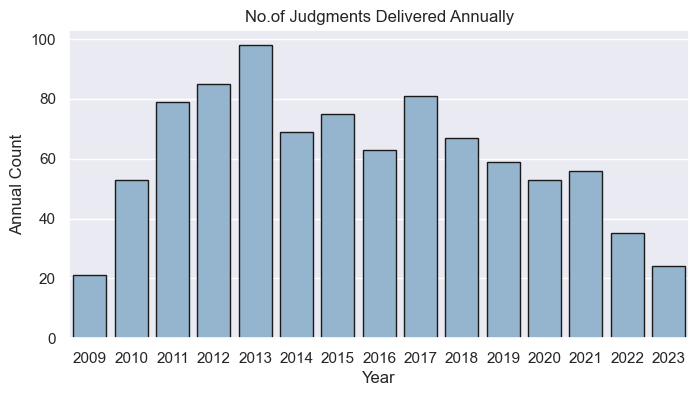

In [68]:
#visualise the no.of judgments delivered each year
sns.set(style="darkgrid")
color=sns.color_palette("Set2")
color1=sns.color_palette("PuBuGn")
plt.figure(figsize=(8,4)) # this creates a figure 8 inch wide, 4 inch high

sns.barplot(x="Year", y="Annual Count", data=UKSC_cases, edgecolor="k", color=color1[2]).set(title="No.of Judgments Delivered Annually")
plt.savefig("NumJudgments_Annually_UKSC_BAR")

No.of Judgments delivered each term

In [69]:
#use groupby to collate judgments delivered during each term
terms = UKSC_df2.groupby(["Term"]).size()

#name the column with the counts
terms = terms.rename("Annual Count").reset_index()
terms

,Term,Annual Count
0,Easter,122
1,Hilary,257
2,Michaelmas,275
3,Trinity,248


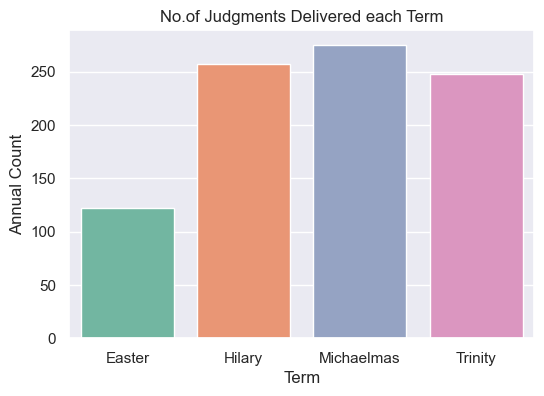

In [15]:
#visualise the no.of judgments delivered each year
plt.figure(figsize=(6,4)) # this creates a figure 8 inch wide, 4 inch high

color=sns.color_palette("Set2")

sns.barplot(x="Term", y="Annual Count", data=terms, palette=color).set(title="No.of Judgments Delivered each Term")
plt.savefig("NumJudgments_Term_UKSC_BAR")

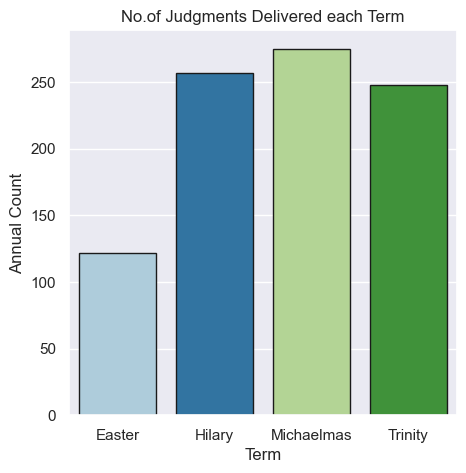

In [76]:
#visualise the no.of judgments delivered each year
plt.figure(figsize=(5,5)) # this creates a figure 8 inch wide, 4 inch high

color2=sns.color_palette("Paired")

sns.barplot(x="Term", y="Annual Count", data=terms, edgecolor="k", palette=color2).set(title="No.of Judgments Delivered each Term")
plt.savefig("NumJudgments_Term_UKSC_BAR2")

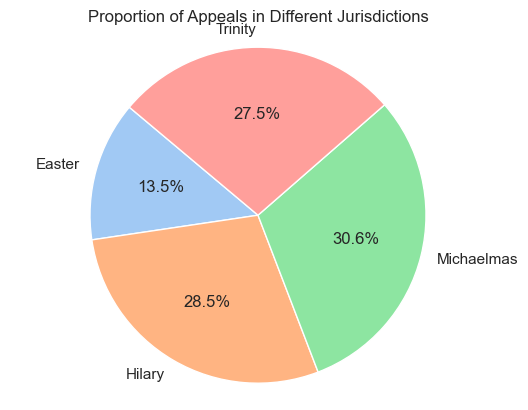

In [28]:
term_count = [121,256,275, 247]
labels = ["Easter","Hilary", "Michaelmas", "Trinity"]
colors=sns.color_palette("pastel")[0:4]

plt.pie(term_count, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
# Customize the plot
plt.title("Proportion of Appeals in Different Jurisdictions")

# Show the plot
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig("NumJudgments_Term_UKSC_PIE.png")
plt.show()

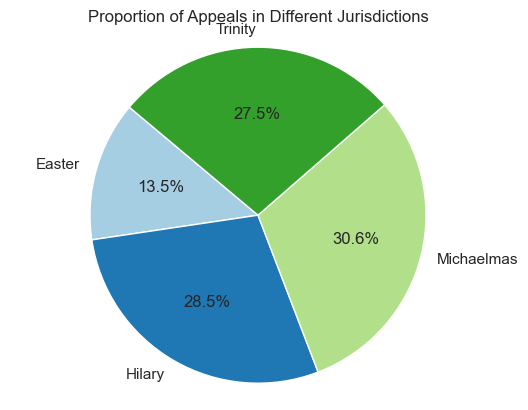

In [80]:
term_count = [121,256,275, 247]
labels = ["Easter","Hilary", "Michaelmas", "Trinity"]
#colors=sns.color_palette("pastel")[0:4]

plt.pie(term_count, labels=labels, colors=color2, autopct='%1.1f%%', startangle=140)
# Customize the plot
plt.title("Proportion of Appeals in Different Jurisdictions")

# Show the plot
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig("NumJudgments_Term_UKSC_PIE2.png")
plt.show()

#### Analysis of Judgments of the lower courts that were appealed

Two questions were explored here. 

First, the no.of cases appealed to the UKSC was examined i.e. how many cases which were decided in a given year were subsequently appealed to the Supreme Court?

Second, the question of where these cases are appealed from was examined i.e. England and Wales, Scotland, Northern Ireland.

To do this, the citation of the case that was appealed was used. 

In [88]:
#extract the year, court, and number to separate columns
UKSC_df2[["Year(LC)", "Court(LC)", "Number(LC)"]] = UKSC_df2["Judgment Appealed"].str.extract(r'(\[?\d+\]?)? ?(\w+ \w+|\w+) (\d+)')

pd.set_option('display.max_rows', None)
UKSC_df2.head(5)
#adjusted to accomodate ones where the year is not in [ ]

,title,text,Judgment Appealed,year of appeal,Term,Judges,Date (judgment),Hearings,Parties,Citation,...,label,Party 1,Party 2,Appellant,Respondent,Reference,Judicial_Review,Year(LC),Court(LC),Number(LC)
0,uksc-2009-0015-judgment-01,Hilary Term [2010] UKSC 1 JUDGMENT Applic...,NaN,2009,Hilary,"Lord Phillips, President Lord Hope, Deputy Pr...",27 January 2010,5 and 22 October 2009 ...,Application by Guardian News and Media Ltd and...,[2010] UKSC 1,...,NaN,Application by Guardian News and Media Ltd and...,Mohammed Jabar Ahmed and others (FC) (Appell...,Mohammed Jabar Ahmed and others (FC) (Appell...,Application by Guardian News and Media Ltd and...,NaN,NaN,NaN,NaN,NaN
1,uksc-2009-0019-judgment,Michaelmas Term [2009] UKSC 5 On appeal from...,[2009] EWCA Civ 545,2009,Michaelmas,"Lord Hope, Deputy President Lady Hale Lord C...",19 November 2009,14 October 2009,In re B (A Child) (2009) (FC),[2009] UKSC 5,...,family,In re B (A Child) (2009) (FC),NaN,NaN,NaN,NaN,NaN,[2009],EWCA Civ,545
2,uksc-2009-0020-judgment,Michaelmas Term [2009] UKSC 12 On appeal fro...,[2009] EWCA Civ 24,2009,Michaelmas,"Lord Phillips, President Lord Hope, Deputy Pr...",9 December 2009,19 and 20 October 2009,R (on the application of A) (Appellant) v B (...,[2009] UKSC 12,...,human rights,R (on the application of A) (Appellant),B (Respondent),R (on the application of A) (Appellant),B (Respondent),NaN,NaN,[2009],EWCA Civ,24
3,uksc-2009-0022-judgment,Easter Term [2011] UKSC 23 On appeal from: [...,[2008] EWCA Civ 1204,2009,Easter,"Lord Hope, Deputy President Lord Rodger Lady...",25 May 2011,10 and 11 February 2010 ...,Shepherd Masimba Kambadzi (previously referred...,[2011] UKSC 23,...,immigration,Shepherd Masimba Kambadzi (previously referred...,Secretary of State for the Home Department (R...,Shepherd Masimba Kambadzi (previously referred...,Secretary of State for the Home Department (R...,NaN,NaN,[2008],EWCA Civ,1204
4,uksc-2009-0031-judgment,Michaelmas Term [2010] UKSC 42 On appeal fro...,2009 EWCA Civ 649,2009,Michaelmas,"Lord Phillips, President Lord Hope, Deputy Pr...",20 October 2010,22 and 23 March 2010,Radmacher (formerly Granatino) (Respondent) v ...,[2010] UKSC 42,...,family,Radmacher (formerly Granatino) (Respondent),Granatino (Appellant),Granatino (Appellant),Radmacher (formerly Granatino) (Respondent),NaN,NaN,2009,EWCA Civ,649


In [89]:
#normalising the year column (removing the [ ])
UKSC_df2["Year(LC)"] = UKSC_df2["Year(LC)"].str.replace("[", "").str.replace("]", "")

C:\Users\Sandani-PC\appdata\Local\Temp\ipykernel_20544\3542171937.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  UKSC_df2["Year(LC)"] = UKSC_df2["Year(LC)"].str.replace("[", "").str.replace("]", "")


In [90]:
UKSC_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              918 non-null    object
 1   text               918 non-null    object
 2   Judgment Appealed  860 non-null    object
 3   year of appeal     918 non-null    int64 
 4   Term               902 non-null    object
 5   Judges             915 non-null    object
 6   Date (judgment)    913 non-null    object
 7   Hearings           899 non-null    object
 8   Parties            918 non-null    object
 9   Citation           918 non-null    object
 10  Year (judgment)    918 non-null    int64 
 11  Press_Decision     754 non-null    object
 12  Final_Decision     715 non-null    object
 13  label              917 non-null    object
 14  Party 1            918 non-null    object
 15  Party 2            855 non-null    object
 16  Appellant          853 non-null    object
 1

In [ ]:
appeal = UKSC_df2.copy()

In [92]:
#drop rows if any of the rows have NaN values
appeal.dropna(subset=["Year(LC)", "Court(LC)", "Number(LC)"], inplace=True)
appeal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 850 entries, 1 to 916
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              850 non-null    object
 1   text               850 non-null    object
 2   Judgment Appealed  850 non-null    object
 3   year of appeal     850 non-null    int64 
 4   Term               836 non-null    object
 5   Judges             847 non-null    object
 6   Date (judgment)    845 non-null    object
 7   Hearings           839 non-null    object
 8   Parties            850 non-null    object
 9   Citation           850 non-null    object
 10  Year (judgment)    850 non-null    int64 
 11  Press_Decision     699 non-null    object
 12  Final_Decision     673 non-null    object
 13  label              850 non-null    object
 14  Party 1            850 non-null    object
 15  Party 2            799 non-null    object
 16  Appellant          801 non-null    object
 1

In [93]:
#to assess how many cases decided by lower courts were appealed each year
#caclulate the no.of cases appealed each year using groupby
appeal1 = appeal.groupby(["Year(LC)"]).size()

##name the column with the counts
appeal1 = appeal1.rename("Annual Count").reset_index()
appeal1

,Year(LC),Annual Count
0,2004,1
1,2007,3
2,2008,19
3,2009,63
4,2010,102
5,2011,81
6,2012,75
7,2013,71
8,2014,74
9,2015,75


In [94]:
#some years are clearly 0.
#added rows for completeness sake
row1 = {"Year(LC)": 2005, "Annual Count": 0}
row2 = {"Year(LC)": 2006, "Annual Count": 0}

appeal1 = appeal1.append(row1, ignore_index=True)
appeal1 = appeal1.append(row2, ignore_index=True)

appeal1

C:\Users\Sandani-PC\appdata\Local\Temp\ipykernel_20544\1214600562.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  appeal1 = appeal1.append(row1, ignore_index=True)
C:\Users\Sandani-PC\appdata\Local\Temp\ipykernel_20544\1214600562.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  appeal1 = appeal1.append(row2, ignore_index=True)


,Year(LC),Annual Count
0,2004,1
1,2007,3
2,2008,19
3,2009,63
4,2010,102
5,2011,81
6,2012,75
7,2013,71
8,2014,74
9,2015,75


In [95]:
#convert Year column to int
appeal1['Year(LC)'] = appeal1['Year(LC)'].astype(int)

#sort column ascending order
appeal1.sort_values(by="Year(LC)", ascending=True, inplace=True)
appeal1

,Year(LC),Annual Count
0,2004,1
17,2005,0
18,2006,0
1,2007,3
2,2008,19
3,2009,63
4,2010,102
5,2011,81
6,2012,75
7,2013,71


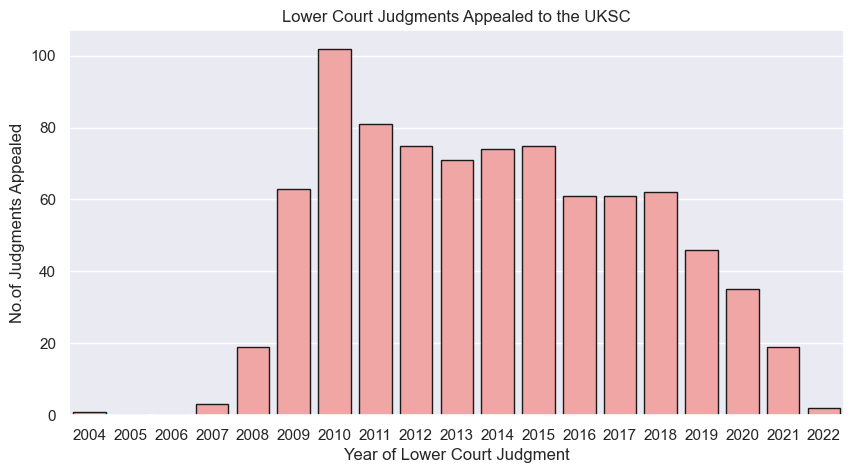

In [97]:
#visualise the no.of cases appealed each year
plt.figure(figsize=(10,5)) # this creates a figure 8 inch wide, 4 inch high

sns.barplot(x="Year(LC)", y="Annual Count", data=appeal1,edgecolor="k", color=color2[4]).set(title="Lower Court Cases Appealed to the UKSC")

plt.xlabel('Year of Lower Court Judgment')
plt.ylabel('No.of Judgments Appealed')
plt.title('Lower Court Judgments Appealed to the UKSC')

plt.savefig("Appeals to the UKSC_Years_BAR2")

In [170]:
#what case decided in 2004 was challenged and when?
appeal.loc[appeal["Year(LC)"] == "2004"]

,title,text,Judgment Appealed,year of appeal,Term,Judges,Date (judgment),Hearings,Parties,Citation,Year (judgment),Press_Decision,Final_Decision,label,Year(LC),Court(LC),Number(LC)
22,uksc-2009-0074-judgment,Easter Term [2013] UKSC 24 On appeal from: [...,[2004] EWCA Civ 559; [2007] EWCA Civ 728,2009,Easter,"Lord Hope, Deputy President Lord Walker Lo...",1 May 2013,"21, 22, 23 and 24 January 2013",WHA Limited and another (Appellants) v Her M...,[2013] UKSC 24,2013,The Supreme Court unanimously dismisses the...,dismiss,insurance,2004,EWCA Civ,559


Examine the Jurisdictions from which the appeals arose.

In [96]:
#calculate how many cases heard in which courts were appealed using groupby
appeal2 = UKSC_df2.groupby(["Court(LC)"]).size()

#name the column with the counts
appeal2 = appeal2.rename("No.of cases").reset_index()

appeal2

,Court(LC),No.of cases
0,CHIH,1
1,CSIH,90
2,ECWA Civ,2
3,ER D,2
4,EWCA,3
5,EWCA Civ,630
6,EWCA Crim,26
7,EWHC,44
8,EWHC Admin,4
9,HCJAC,12


In [97]:
#what case was decided by the QB?
appeal.loc[appeal["Court(LC)"] == "QB"]

#the jurisdiction of this case is still unclear as citation doesn't specificy
#WHICH QB it emanated from

,title,text,Judgment Appealed,year of appeal,Term,Judges,Date (judgment),Hearings,Parties,Citation,...,label,Party 1,Party 2,Appellant,Respondent,Reference,Judicial_Review,Year(LC),Court(LC),Number(LC)
304,uksc-2012-0113-judgment,Hilary Term [2014] UKSC 10 On appeal from: ...,[2013] QB 499,2012,Hilary,"Lord Neuberger, President Lord Mance Lord C...",19 February 2014,4 and 5 November 2013,Williams (Respondent) v Central Bank of Nigeri...,[2014] UKSC 10,...,fraud,Williams (Respondent),Central Bank of Nigeria (Appellant),Central Bank of Nigeria (Appellant),Williams (Respondent),NaN,NaN,2013,QB,499


In [98]:
#create new df with case counts from different jurisdictions

data = [["England and Wales", 732], ["Northern Ireland", 35], ["Scotland", 103], ["Other", 5]]
compiled_df = pd.DataFrame(data, columns=["Jurisdiction", "No.of Appeals"])
compiled_df

,Jurisdiction,No.of Appeals
0,England and Wales,732
1,Northern Ireland,35
2,Scotland,103
3,Other,5


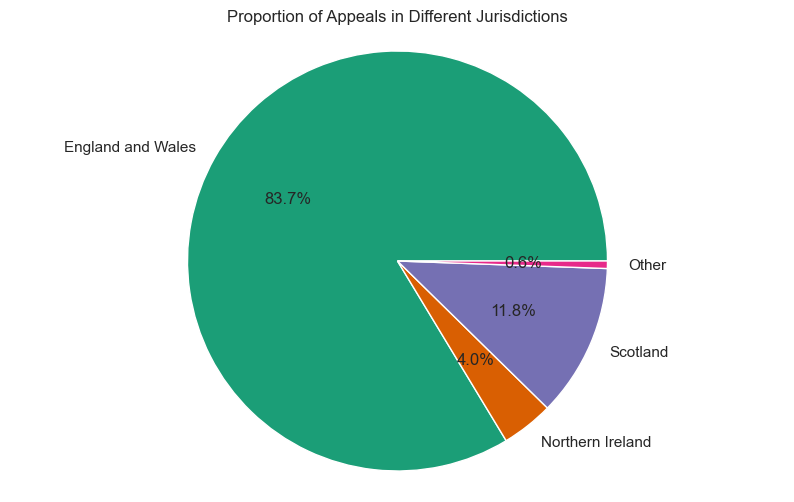

In [120]:
appeals_count = [732,35,103, 5]
labels = ["England and Wales","Northern Ireland", "Scotland", "Other"]
#colors = ["skyblue", "lightcoral", "lightgreen", ]
colors=sns.color_palette("Dark2")

plt.figure(figsize=(10, 6))
plt.pie(appeals_count, labels = labels, colors=colors, autopct='%1.1f%%')
# Customize the plot
plt.title("Proportion of Appeals in Different Jurisdictions")

# Show the plot
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig("Proportion of Appeals_Jurisdictions.png")
plt.show()

### Laws Delays

This section queries the time taken from the point of getting the lower court decision to getting the UKSC decision based on the years in the citations.

1. How long does it take from getting the lower court decision to getting the UKSC decision?

In [99]:
#to perform time analysis, a separate df is prepared
time = UKSC_df2.copy()

#NaN rows dropped
time.dropna(subset=["Year(LC)", "Year (judgment)"], inplace=True)
time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 850 entries, 1 to 916
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              850 non-null    object
 1   text               850 non-null    object
 2   Judgment Appealed  850 non-null    object
 3   year of appeal     850 non-null    int64 
 4   Term               836 non-null    object
 5   Judges             847 non-null    object
 6   Date (judgment)    845 non-null    object
 7   Hearings           839 non-null    object
 8   Parties            850 non-null    object
 9   Citation           850 non-null    object
 10  Year (judgment)    850 non-null    int64 
 11  Press_Decision     699 non-null    object
 12  Final_Decision     673 non-null    object
 13  label              850 non-null    object
 14  Party 1            850 non-null    object
 15  Party 2            799 non-null    object
 16  Appellant          801 non-null    object
 1

In [100]:
time['Year (judgment)'] = time['Year (judgment)'].astype(int)
time['Year(LC)'] = time['Year(LC)'].astype(int)

In [101]:
#calculate difference between year of lower court decision and year of UKSC decision
time["No.of Years"] = (time["Year (judgment)"] - time["Year(LC)"])
time.head(4)

,title,text,Judgment Appealed,year of appeal,Term,Judges,Date (judgment),Hearings,Parties,Citation,...,Party 1,Party 2,Appellant,Respondent,Reference,Judicial_Review,Year(LC),Court(LC),Number(LC),No.of Years
1,uksc-2009-0019-judgment,Michaelmas Term [2009] UKSC 5 On appeal from...,[2009] EWCA Civ 545,2009,Michaelmas,"Lord Hope, Deputy President Lady Hale Lord C...",19 November 2009,14 October 2009,In re B (A Child) (2009) (FC),[2009] UKSC 5,...,In re B (A Child) (2009) (FC),NaN,NaN,NaN,NaN,NaN,2009,EWCA Civ,545,0
2,uksc-2009-0020-judgment,Michaelmas Term [2009] UKSC 12 On appeal fro...,[2009] EWCA Civ 24,2009,Michaelmas,"Lord Phillips, President Lord Hope, Deputy Pr...",9 December 2009,19 and 20 October 2009,R (on the application of A) (Appellant) v B (...,[2009] UKSC 12,...,R (on the application of A) (Appellant),B (Respondent),R (on the application of A) (Appellant),B (Respondent),NaN,NaN,2009,EWCA Civ,24,0
3,uksc-2009-0022-judgment,Easter Term [2011] UKSC 23 On appeal from: [...,[2008] EWCA Civ 1204,2009,Easter,"Lord Hope, Deputy President Lord Rodger Lady...",25 May 2011,10 and 11 February 2010 ...,Shepherd Masimba Kambadzi (previously referred...,[2011] UKSC 23,...,Shepherd Masimba Kambadzi (previously referred...,Secretary of State for the Home Department (R...,Shepherd Masimba Kambadzi (previously referred...,Secretary of State for the Home Department (R...,NaN,NaN,2008,EWCA Civ,1204,3
4,uksc-2009-0031-judgment,Michaelmas Term [2010] UKSC 42 On appeal fro...,2009 EWCA Civ 649,2009,Michaelmas,"Lord Phillips, President Lord Hope, Deputy Pr...",20 October 2010,22 and 23 March 2010,Radmacher (formerly Granatino) (Respondent) v ...,[2010] UKSC 42,...,Radmacher (formerly Granatino) (Respondent),Granatino (Appellant),Granatino (Appellant),Radmacher (formerly Granatino) (Respondent),NaN,NaN,2009,EWCA Civ,649,1


In [103]:
numYears = time["No.of Years"].describe()
print(numYears)

count    850.000000
mean       1.717647
std        0.910762
min        0.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        9.000000
Name: No.of Years, dtype: float64


In [104]:
#average no.of years taken from lower court decision to UKSC judgment
aveYears = time["No.of Years"].mean()
print("Average no.of years : ", aveYears)

months = aveYears*12
print("Average time (in months): ", months)

Average no.of years :  1.7176470588235293
Average time (in months):  20.61176470588235


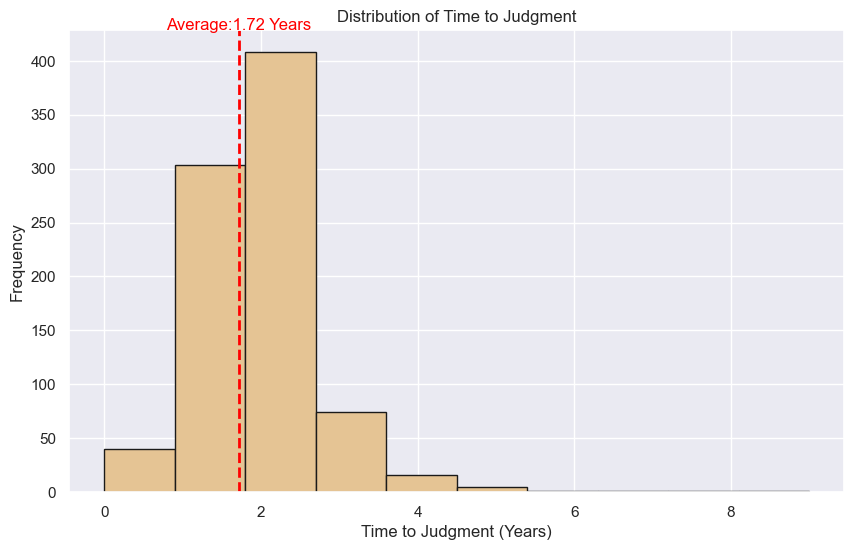

In [297]:
#plot a histogram to visualise distribution of time to judgment
plt.figure(figsize=(10, 6))
plt.hist(time['No.of Years'], bins=10, edgecolor='k', color=color[6])
ave_line = np.mean(time['No.of Years'])

plt.axvline(ave_line, color='red', linestyle='dashed', linewidth=2, label=f'Average: {ave_line:.2f}')
#plt.text(ave_line, plt.ylim()[1]*0.9, f'Average:{ave_line:.2f} Years', color='red', fontsize=13, ha='center')
plt.text(ave_line, plt.ylim()[1] + 0.00 * plt.ylim()[1], f'Average:{ave_line:.2f} Years', color='red', fontsize=12, ha='center')

#plt.ylim adjusted so that "Average 1.72 Years" is not obstructed by redline.

plt.xlabel('Time to Judgment (Years)')
plt.ylabel('Frequency')
plt.title('Distribution of Time to Judgment')

plt.savefig("Distribution_Time to Judgment_LC-UKSC")

plt.show()

#the shape of the histogram is positively skewed (tail extends to the right)
#seems uni-modal (only one underlying distribution)
#central tendency (highest bar) - most frequent value (as it's skewed)
#low variability - bars are narrower and taller
#there are definite outliers - after around 2 years

Extract the last date of hearing

In [105]:
#extracting the final hearing date from all hearing dates
time["Last Hearing"] = time["Hearings"].str.extract(r'(\d{1,2} [\w,]+ \d{4})')

#\d (digits) {1,2} (one or two digits) [\w,]+ (one/more words in a set of characters with a comma) \d (digits) {4} 4 digits

In [129]:
print(time["Last Hearing"].to_string(index=False))

 14 October 2009
 20 October 2009
11 February 2010
   23 March 2010
    24 June 2010
 4 November 2009
     17 May 2012
   22 April 2010
    28 July 2009
    23 July 2012
15 December 2009
    29 July 2009
 3 December 2009
24 November 2009
 1 December 2009
     12 May 2010
     12 May 2010
   25 March 2010
    25 June 2009
23 February 2010
     9 July 2009
 24 January 2013
 13 October 2009
 2 February 2010
    11 June 2009
     12 May 2010
    30 July 2009
   17 March 2010
    14 July 2009
 29 October 2009
    23 July 2009
24 November 2010
24 November 2010
   10 March 2010
    16 July 2009
 14 January 2010
   27 April 2010
22 November 2012
15 February 2010
 9 December 2009
 8 December 2009
    22 July 2010
 29 October 2009
     2 July 2009
 4 February 2010
  5 October 2010
     18 May 2010
   15 April 2010
 25 October 2012
    19 July 2010
    30 June 2010
13 December 2010
 20 January 2010
17 November 2009
    2 March 2010
   20 April 2010
 9 November 2010
30 November 2010
     8 July 20

In [109]:
#convert date of judgment to datetime

#remove leading whitespace
time["Date (judgment)"] = time["Date (judgment)"].str.lstrip()

#lstrip used to remove leading whitespace in ' 17 December 2014' - if strip used, would remove both leading and trailing whitespace
#https://stackoverflow.com/questions/959215/how-do-i-remove-leading-whitespace-in-python

In [110]:
#remove any nd|nd|th (18th)
time["Date (judgment)"] = time["Date (judgment)"].replace(r'nd|rd|th', '', regex=True)
#remove days of the week
time["Date (judgment)"] = time["Date (judgment)"].replace(r'Monday|Tuesday|Wednesday|Thursday|Friday', '', regex=True)

#date of judgment converted to dt format
time["DoJ"] = pd.to_datetime(time["Date (judgment)"], format='%d %B %Y')

#date of final hearing converted to dt format
time["DoFH"] = pd.to_datetime(time["Last Hearing"], format='%d %B %Y')

#18th September 2014 was a problem, so th was removed
#not include st as it could take out August-Augu
#Wednesday removed

In [111]:
#deduct date of judgment from final date of hearing
time["H_Jdays"] = (time["DoJ"] - time["DoFH"]).dt.days
time.info()

#https://practicaldatascience.co.uk/data-science/how-to-calculate-the-time-difference-between-two-dates-in-pandas#:~:text=There%20are%20several%20ways%20to,seconds%20between%20the%20two%20dates.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 850 entries, 1 to 916
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   title              850 non-null    object        
 1   text               850 non-null    object        
 2   Judgment Appealed  850 non-null    object        
 3   year of appeal     850 non-null    int64         
 4   Term               836 non-null    object        
 5   Judges             847 non-null    object        
 6   Date (judgment)    845 non-null    object        
 7   Hearings           839 non-null    object        
 8   Parties            850 non-null    object        
 9   Citation           850 non-null    object        
 10  Year (judgment)    850 non-null    int32         
 11  Press_Decision     699 non-null    object        
 12  Final_Decision     673 non-null    object        
 13  label              850 non-null    object        
 14  Party 1   

In [ ]:
print(time["H_Jdays"].to_string(index=False))

In [113]:
#get summary statistics
hearing_judgment_SUM = time["H_Jdays"].describe()
print(hearing_judgment_SUM)

count     835.000000
mean      114.106587
std        84.704179
min      -204.000000
25%        62.000000
50%        98.000000
75%       140.500000
max      1009.000000
Name: H_Jdays, dtype: float64


In [114]:
#what case is -1??
time.loc[time["H_Jdays"] == -204]

#investigate - 204 in dataset
#uksc-2011-0124-judgment
#this is a clerical error in the judgment which lists dates of hearings after the date of judgment

,title,text,Judgment Appealed,year of appeal,Term,Judges,Date (judgment),Hearings,Parties,Citation,...,Reference,Judicial_Review,Year(LC),Court(LC),Number(LC),No.of Years,Last Hearing,DoJ,DoFH,H_Jdays
215,uksc-2011-0124-judgment,Easter Term [2013] UKSC 23 On appeal from: [...,[2011] EWCA Civ 349; [2012] EWCA Civ 452,2011,Easter,"Lord Neuberger, President Lord Mance Lord ...",1 May 2013,"19, 20 and 21 November 2013",R (on the application of Faulkner) (FC) (Appel...,[2013] UKSC 23,...,NaN,NaN,2011,EWCA Civ,349,2,21 November 2013,2013-05-01,2013-11-21,-204.0


In [115]:
#therefore the relevant row is removed
time = time[time['title'] != 'uksc-2011-0124-judgment']

In [117]:
#rerun descriptive statistics function
hearing_judgment_SUM2 = time["H_Jdays"].describe()
print(hearing_judgment_SUM2)

#minimum no.of days is now 8 (not -204)

count     834.000000
mean      114.488010
std        84.034438
min         8.000000
25%        62.000000
50%        98.000000
75%       140.750000
max      1009.000000
Name: H_Jdays, dtype: float64


In [118]:
time.loc[time["H_Jdays"] == 8]

,title,text,Judgment Appealed,year of appeal,Term,Judges,Date (judgment),Hearings,Parties,Citation,...,Reference,Judicial_Review,Year(LC),Court(LC),Number(LC),No.of Years,Last Hearing,DoJ,DoFH,H_Jdays
568,uksc-2015-0176-judgment,Michaelmas Term [2015] UKSC 70 On appeal fro...,[2015] EWCA Civ 329,2015,Michaelmas,"Lady Hale, Deputy President Lord Wilson Lord...",25 November 2015,17 November 2015,In the matter of J (a child),[2015] UKSC 70,...,NaN,NaN,2015,EWCA Civ,329,0,17 November 2015,2015-11-25,2015-11-17,8.0


In [119]:
#average no.of days taken from hearing to judgment in UKSC
ave = time["H_Jdays"].mean()
print("Average no.of days: ", ave)
years = ave/365
months = ave/30
print("Average time (in months): ", months)
print("Average time (in years): ", years)

Average no.of days:  114.48800959232614
Average time (in months):  3.8162669864108714
Average time (in years):  0.3136657797050031


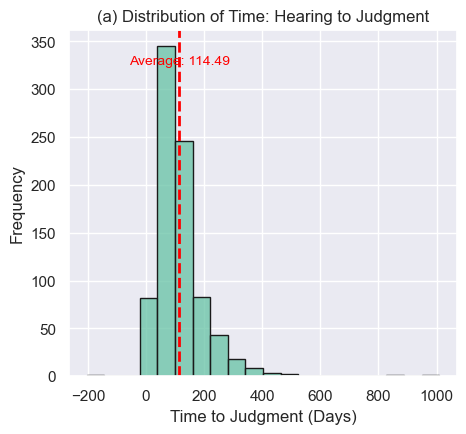

In [317]:
#plot a histogram to visualise distribution of time to judgment
plt.figure(figsize=(5, 4.5))
sns.set(style="darkgrid")

sns.histplot(time2['H_Jdays'], bins=20, edgecolor='k', color=color[0])
ave_line = np.mean(time["H_Jdays"])

plt.axvline(ave_line, color='red', linestyle='dashed', linewidth=2, label=f'Average: {ave_line:.2f}')
plt.text(ave_line, plt.ylim()[1]*0.9, f'Average: {ave_line:.2f}', color='red', fontsize=10, ha='center')


plt.xlabel('Time to Judgment (Days)')
plt.ylabel('Frequency')
plt.title('(a) Distribution of Time: Hearing to Judgment')

plt.savefig("Distribution_Time to Judgment_BAR")

plt.show()

#the shape of the histogram is positively skewed (tail extends to the right)
#seems uni-modal (only one underlying distribution)
#central tendency (highest bar) - most frequent value (as it's skewed)
#low variability - bars are narrower and taller
#there are definite outliers - after around 400 days

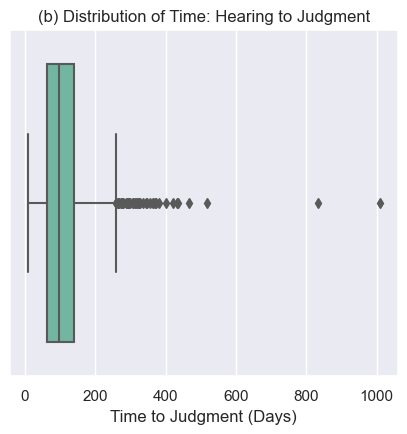

In [318]:
#plot a histogram to visualise distribution of time to judgment
plt.figure(figsize=(5, 4.5))
sns.boxplot(x=time['H_Jdays'], color=color[0] )
plt.xlabel('Time to Judgment (Days)')
plt.title('(b) Distribution of Time: Hearing to Judgment')

plt.savefig("Distribution_Time to Judgment_BOXPLOT")

plt.show()

In [121]:
H_J = time["H_Jdays"]
#H_J.value_counts()

days_list = time["H_Jdays"]

#define bins for intervals:
bins = [0,30, 60, 90, 120, 150, 180, 360,550,720,1080, float("inf")]

#labels for bins
labels = ["1 month", "2 months", "3 months", "4 months", "5 months", "6 months", "12 months", "18 months", "24 months", "36 months", "36+ months"]

#Cut the days into the specified bins and count occurrences in each bin
binned_days = pd.cut(days_list, bins=bins, labels=labels, right=False)
days_counts = binned_days.value_counts().reindex(labels, fill_value=0)

print(days_counts)

1 month        39
2 months      167
3 months      157
4 months      173
5 months      117
6 months       60
12 months     108
18 months      11
24 months       0
36 months       2
36+ months      0
Name: H_Jdays, dtype: int64


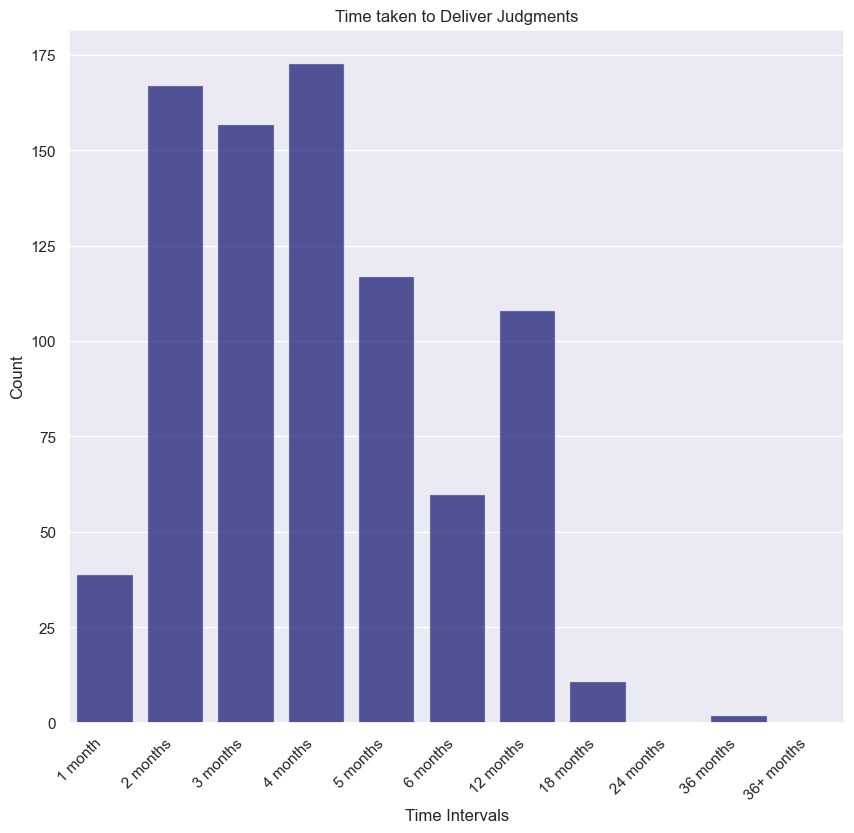

In [159]:
# Plot the bar chart
plt.figure(figsize=(10,9))
#plt.bar(days_counts.index, days_counts.values, color='blue', alpha=0.7)
plt.xlabel('Time Intervals')
plt.ylabel('Count')
plt.title('Distribution of Number of Days')
plt.xticks(rotation=45, ha='right')
#plt.show()

#seq_colors = sns.color_palette("Reds", 10)
sns.barplot(x=days_counts.index, y=days_counts.values, alpha=0.7, color="navy").set(title="Time taken to Deliver Judgments")
plt.savefig("Time taken to Judgments Appealed to the UKSC")

In [123]:
time_trends = time.copy()
#does time taken to judgment (from hearing) change over time?
#are cases resolved slower or faster in recent years?

time_trends["Hearing_year"] = pd.to_datetime(time_trends["Last Hearing"]).dt.year
grouped_dates = time_trends.groupby("Hearing_year")
ave_time = grouped_dates["H_Jdays"].mean()

print("Average No.of Days taken to deliver judgment (after hearing): ", ave_time)

Average No.of Days taken to deliver judgment (after hearing):  Hearing_year
2009.0     92.708333
2010.0     92.867925
2011.0     97.121212
2012.0     81.746667
2013.0     85.441176
2014.0    113.225806
2015.0    112.140625
2016.0    129.226667
2017.0    110.823529
2018.0    122.573770
2019.0    165.160714
2020.0    173.152174
2021.0    151.931818
2022.0    129.222222
2023.0     71.818182
Name: H_Jdays, dtype: float64


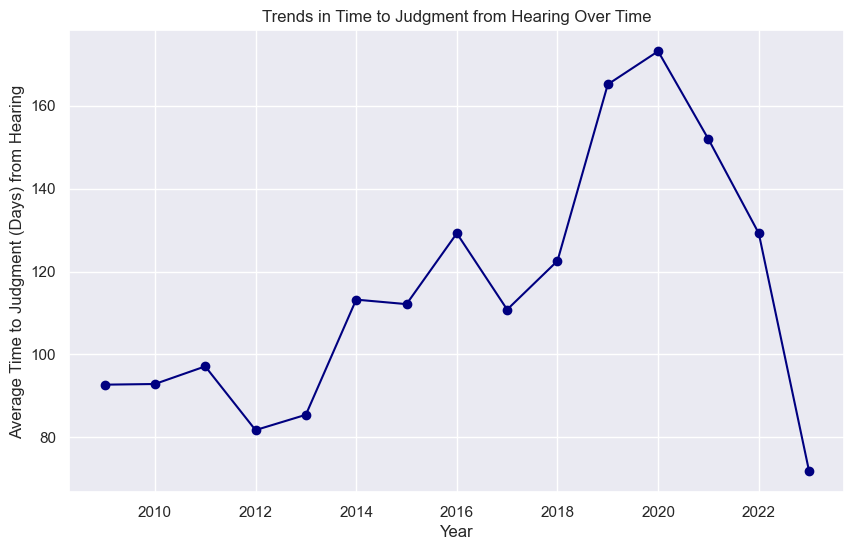

In [164]:
set3 = color=sns.color_palette("Set3")

plt.figure(figsize=(10, 6))
plt.plot(ave_time.index, ave_time.values, marker='o', linestyle='-', color="navy")
plt.xlabel('Year')
plt.ylabel('Average Time to Judgment (Days) from Hearing')
plt.title('Trends in Time to Judgment from Hearing Over Time')
plt.grid(True)

plt.savefig("Trends in Time to Judgment from Hearing")
plt.show()

In [125]:
case_vol = time.copy()

#calculate case volume
vol = case_vol.groupby("Last Hearing")["title"].count().reset_index()
vol.rename(columns={"title": "Case Volume"}, inplace=True)
vol

#generally, the UKSC hears one case or so a day

,Last Hearing,Case Volume
0,1 April 2014,1
1,1 December 2009,1
2,1 December 2015,1
3,1 December 2020,1
4,1 December 2021,1
5,1 December 2022,1
6,1 February 2017,1
7,1 February 2018,1
8,1 July 2021,1
9,1 March 2018,1


In [126]:
vol_desc = vol["Case Volume"].describe()
print(vol_desc)

count    729.000000
mean       1.146776
std        0.538740
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        9.000000
Name: Case Volume, dtype: float64


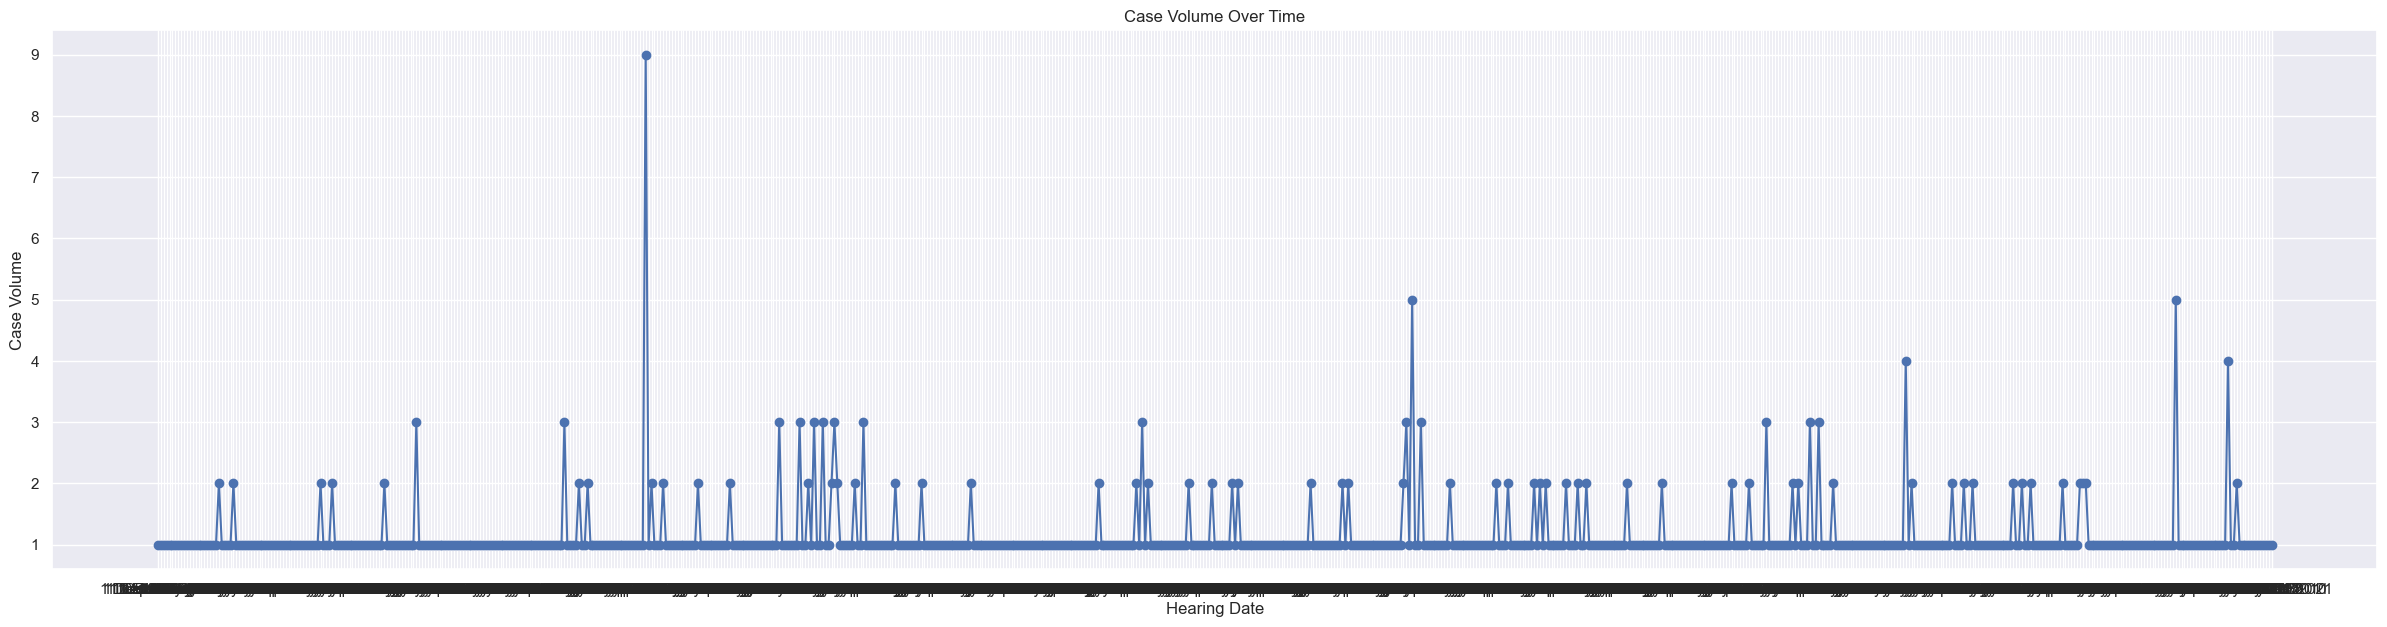

In [181]:
plt.figure(figsize=(30, 7))
plt.plot(vol["Last Hearing"], vol["Case Volume"], marker='o', linestyle='-')
plt.xlabel('Hearing Date')
plt.ylabel('Case Volume')
plt.title('Case Volume Over Time')
plt.grid(True)
plt.savefig("Case Volume Over Time_2009_23")
plt.show()

### Analysis of Decisions

In [127]:
decisions = UKSC_df2.copy()
decisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   title              918 non-null    object
 1   text               918 non-null    object
 2   Judgment Appealed  860 non-null    object
 3   year of appeal     918 non-null    int64 
 4   Term               902 non-null    object
 5   Judges             915 non-null    object
 6   Date (judgment)    913 non-null    object
 7   Hearings           899 non-null    object
 8   Parties            918 non-null    object
 9   Citation           918 non-null    object
 10  Year (judgment)    918 non-null    int64 
 11  Press_Decision     754 non-null    object
 12  Final_Decision     715 non-null    object
 13  label              917 non-null    object
 14  Party 1            918 non-null    object
 15  Party 2            855 non-null    object
 16  Appellant          853 non-null    object
 1

In [128]:
#examine how the UKSC has decided
decisions["Final_Decision"].value_counts()

dismiss                   370
allow                     341
legislative competence      4
Name: Final_Decision, dtype: int64

In [130]:
#replace "legislative competence" with NaN
decisions["Final_Decision"] = decisions["Final_Decision"].replace("legislative competence", np.nan)

decisions["Final_Decision"].value_counts()

dismiss    370
allow      341
Name: Final_Decision, dtype: int64

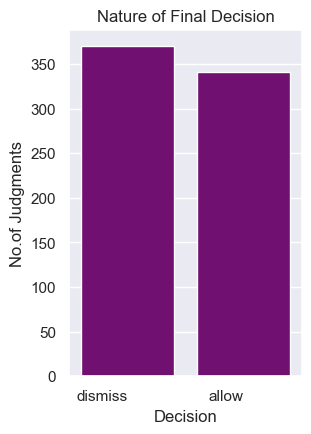

In [169]:
#bar plot
#decisions.Final_Decision.value_counts().sort_values().plot(kind="bar")
#sns.barplot(x="Final_Decision", data=decisions)

plt.figure(figsize=(3,4.5))

sns.barplot(x=decisions.Final_Decision.value_counts().index, y=decisions.Final_Decision.value_counts(), color="purple")

plt.xlabel('Decision')
plt.ylabel('No.of Judgments')
plt.title('Nature of Final Decision')
plt.xticks(rotation=360, ha='right')

plt.savefig("NumDecisions_BAR")

In [131]:
decision_trends = decisions.groupby(["Year (judgment)", "Final_Decision"]).size().unstack()
decision_trends

Final_Decision,allow,dismiss
Year (judgment),,
2009,7.0,9.0
2010,22.0,27.0
2011,40.0,31.0
2012,31.0,48.0
2013,40.0,48.0
2014,35.0,31.0
2015,36.0,36.0
2016,29.0,31.0
2017,43.0,34.0


<Figure size 1000x1000 with 0 Axes>

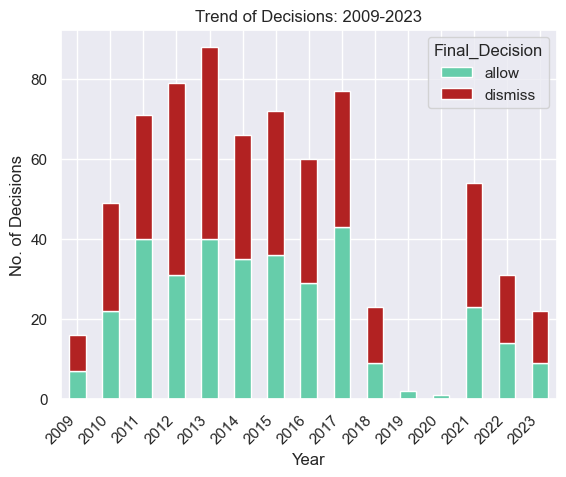

In [172]:
#trends in how decisions are made?
plt.figure(figsize=(10,10))

decision_trends.plot(kind="bar", stacked=True, color=["mediumaquamarine", "firebrick"])

plt.xlabel('Year')
plt.ylabel('No. of Decisions')
plt.title('Trend of Decisions: 2009-2023')
plt.xticks(rotation=45, ha='right', fontsize=11)

plt.savefig("Trend_Decisions_BAR")

<Figure size 800x400 with 0 Axes>

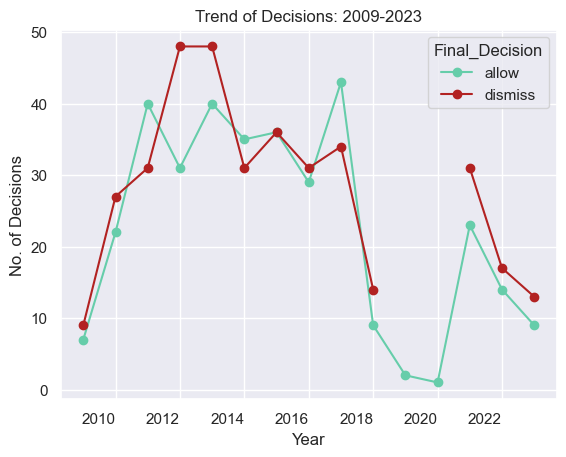

In [173]:
plt.figure(figsize=(8,4))

decision_trends = decisions.groupby(["Year (judgment)", "Final_Decision"]).size().unstack()

decision_trends.plot(kind="line", marker="o", color=["mediumaquamarine", "firebrick"])

plt.xlabel("Year")
plt.ylabel("No. of Decisions")
plt.title("Trend of Decisions: 2009-2023")
plt.xticks(rotation=360, ha='right')

plt.savefig("Trend_Decisions_LINE")

In [174]:
decision_trend_term = decisions.groupby(["Term", "Final_Decision"]).size().unstack()
decision_trend_term

Final_Decision,allow,dismiss
Term,,
Easter,46,50
Hilary,100,93
Michaelmas,96,127
Trinity,93,97


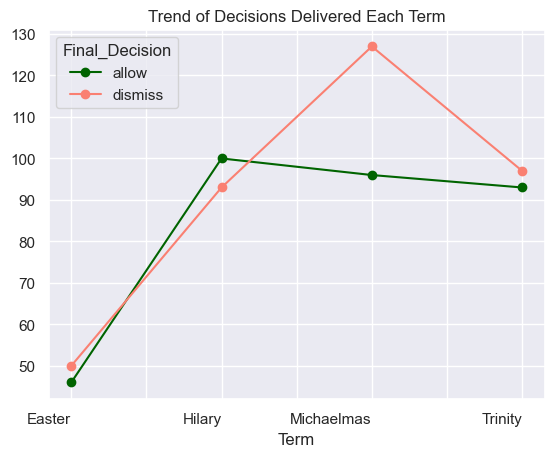

In [175]:
decision_trend_term.plot(kind="line", marker="o", color=["darkgreen", "salmon"])
plt.xlabel('Term')
#plt.ylabel('No. of Decisions')
plt.title('Trend of Decisions Delivered Each Term')
plt.xticks(rotation=360, ha='right')

plt.savefig("Trend_Decisions_Term_LINE")

In [132]:
decision_time_trend = case_vol.groupby(["H_Jdays", "Final_Decision"]).mean()
decision_time_trend

C:\Users\Sandani-PC\appdata\Local\Temp\ipykernel_20544\2750864367.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  decision_time_trend = case_vol.groupby(["H_Jdays", "Final_Decision"]).mean()


year of appeal  Year (judgment)     Year(LC)  \
H_Jdays Final_Decision                                                 
8.0     allow              2015.000000      2015.000000  2015.000000   
9.0     dismiss            2015.000000      2015.000000  2014.000000   
13.0    dismiss            2012.000000      2012.000000  2012.000000   
15.0    dismiss            2009.000000      2010.000000  2009.000000   
16.0    allow              2013.000000      2013.000000  2013.000000   
17.0    dismiss            2013.500000      2013.500000  2013.000000   
18.0    allow              2009.000000      2009.000000  2009.000000   
21.0    allow              2015.000000      2016.000000  2015.000000   
        dismiss            2011.500000      2012.500000  2011.500000   
22.0    allow              2012.000000      2013.000000  2012.000000   
        dismiss            2010.500000      2012.500000  2010.500000   
23.0    allow              2013.500000      2014.500000  2013.500000   
27.0    allow              2014.400000      2015.600000  2014.200000   
        dismiss            2011.666667      2012.666667  2011.666667   
28.0    allow              2013.333333      2014.333333  2013.333333   
        dismiss            2012.500000      2014.500000  2012.500000   
29.0    dismiss            2013.400000      2014.200000  2013.200000   
30.0    allow              2011.000000      2012.333333  2011.000000   
        dismiss            2012.333333      2013.000000  2011.333333   
31.0    dismiss            2013.000000      2013.000000  2012.000000   
34.0    allow              2012.333333      2013.666667  2012.166667   
        dismiss            2012.500000      2014.000000  2012.333333   
35.0    allow              2011.000000      2012.000000  2011.000000   
        dismiss            2012.000000      2013.666667  2011.666667   
36.0    allow              2011.800000      2012.800000  2011.800000   
        dismiss            2010.600000      2011.400000  2009.800000   
37.0    allow              2011.000000      2012.500000  2011.000000   
        dismiss            2012.000000      2013.500000  2012.000000   
40.0    allow              2016.000000      2017.000000  2015.000000   
41.0    allow              2013.125000      2014.375000  2012.875000   
        dismiss            2011.625000      2012.625000  2011.375000   
42.0    allow              2010.000000      2010.750000  2009.750000   
        dismiss            2013.500000      2014.500000  2013.000000   
43.0    allow              2013.500000      2014.500000  2013.000000   
        dismiss            2016.500000      2017.500000  2015.500000   
44.0    allow              2014.000000      2014.666667  2013.666667   
        dismiss            2012.666667      2013.000000  2012.333333   
45.0    dismiss            2017.000000      2017.000000  2016.000000   
47.0    dismiss            2016.000000      2017.000000  2016.000000   
48.0    allow              2014.600000      2015.800000  2014.400000   
        dismiss            2012.333333      2013.000000  2012.333333   
49.0    allow              2012.333333      2013.500000  2012.000000   
        dismiss            2013.333333      2014.333333  2012.666667   
50.0    allow              2011.000000      2012.000000  2011.000000   
        dismiss            2010.800000      2011.600000  2010.200000   
51.0    allow              2020.000000      2021.000000  2020.000000   
        dismiss            2017.000000      2019.500000  2016.500000   
52.0    allow              2012.000000      2014.000000  2012.000000   
53.0    dismiss            2014.000000      2015.000000  2014.000000   
55.0    allow              2011.000000      2011.666667  2010.666667   
        dismiss            2013.750000      2014.500000  2013.500000   
56.0    allow              2013.285714      2014.500000  2013.071429   
        dismiss            2013.666667      2015.333333  2013.666667   
57.0    allow              2011.666667      2013.166667  2011.00

In [137]:
case_vol2 = case_vol.copy()
case_vol2.dropna(subset=["H_Jdays", "Final_Decision"], inplace=True)
case_vol2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659 entries, 1 to 914
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   title              659 non-null    object        
 1   text               659 non-null    object        
 2   Judgment Appealed  659 non-null    object        
 3   year of appeal     659 non-null    int64         
 4   Term               650 non-null    object        
 5   Judges             658 non-null    object        
 6   Date (judgment)    659 non-null    object        
 7   Hearings           659 non-null    object        
 8   Parties            659 non-null    object        
 9   Citation           659 non-null    object        
 10  Year (judgment)    659 non-null    int32         
 11  Press_Decision     659 non-null    object        
 12  Final_Decision     659 non-null    object        
 13  label              659 non-null    object        
 14  Party 1   

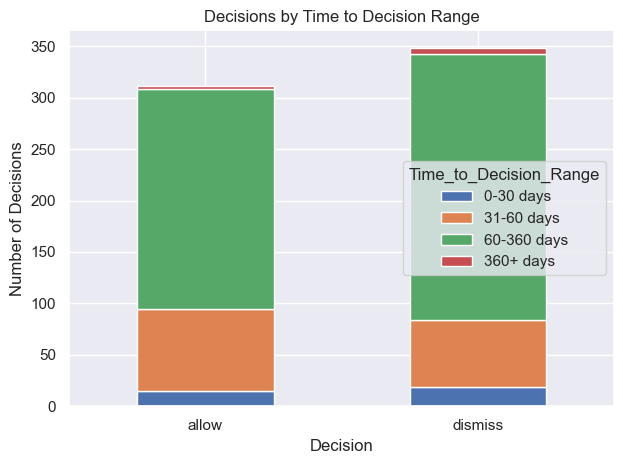

In [187]:
bins = [0, 30, 60, 360, np.inf]
labels = ['0-30 days', '31-60 days', '60-360 days', "360+ days"]

# Create a new column with time to decision ranges
case_vol2['Time_to_Decision_Range'] = pd.cut(case_vol2['H_Jdays'], bins=bins, labels=labels, right=False)

# Group data by Decision and Time to Decision Range, and calculate the counts
decision_time_counts = case_vol2.groupby(['Final_Decision', 'Time_to_Decision_Range']).size().unstack()

# Plot the results using a bar plot
ax = decision_time_counts.plot(kind='bar', stacked=True)

# Customize the plot
plt.xlabel('Decision')
plt.ylabel('Number of Decisions')
plt.title('Decisions by Time to Decision Range')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Explore Labels

In [189]:
#no. of unique labels
unique_labels = UKSC_df2["label"].nunique()
unique_labels

41

In [190]:
UKSC_df2.label.value_counts()
#https://www.statology.org/pandas-unique-values-in-column/

criminal                    99
immigration                 98
admin                       95
human rights                75
international               65
tax                         62
labour                      51
contract                    49
land                        47
tort                        46
company                     45
family                      37
insurance                   25
procedure                   20
constitutional              19
intellectual property       19
shipping                     7
mental capacity              6
arbitration                  6
competition                  5
equity                       5
banking                      4
civil                        4
security                     3
trust                        3
damages                      3
mental health                2
jurisdiction                 2
public                       2
contempt                     2
public health                1
fraud                        1
telecom 

In [235]:
#how long, on average, to decide cases in specific areas of law?
label_decision1 = case_vol2.groupby("label")["H_Jdays"].mean()
label_decision1

label
admin                        98.676471
arbitration                 112.333333
banking                      93.000000
civil                       128.500000
company                     119.512821
competition                  76.500000
constitutional               76.428571
consumer protection          62.000000
contempt                     63.000000
contract                    103.600000
criminal                    112.687500
damages                     194.000000
equity                      164.000000
family                       79.555556
fishing                      83.000000
fraud                       106.000000
human rights                122.166667
immigration                 115.360000
insurance                   100.600000
intellectual property       102.416667
international               141.952381
jurisdiction                 38.000000
labour                      112.657143
land                         74.250000
legal aid                    55.000000
medical            

In [245]:
#because the labels with less cases are skewing the data, labels with
#less than 4 cases are dropped

dropped_labels1 = ["legal aid", "telecom", "private", "consumer protection",
                  "contempt", "statutory interpretation", "public", "medical",
                  "public health", "fraud", "fishing", "jurisdiction",
                  "mental health", "civil", "competition", "trust", " banking"
                  "arbitration", "security", "damages", "equity", "mental capacity",
                 "shipping", "medical ", "banking ", " banking "]

label_decision_new1 = case_vol2[~case_vol2['label'].isin(dropped_labels1)]

#check the necessary labels have been dropped
#round average to 0 decimal points
label_decision1 = label_decision_new1.groupby("label")["H_Jdays"].mean().round(0)
label_decision1

label
admin                     99.0
arbitration              112.0
banking                   93.0
company                  120.0
constitutional            76.0
contract                 104.0
criminal                 113.0
family                    80.0
human rights             122.0
immigration              115.0
insurance                101.0
intellectual property    102.0
international            142.0
labour                   113.0
land                      74.0
procedure                116.0
tax                      105.0
tort                     138.0
Name: H_Jdays, dtype: float64

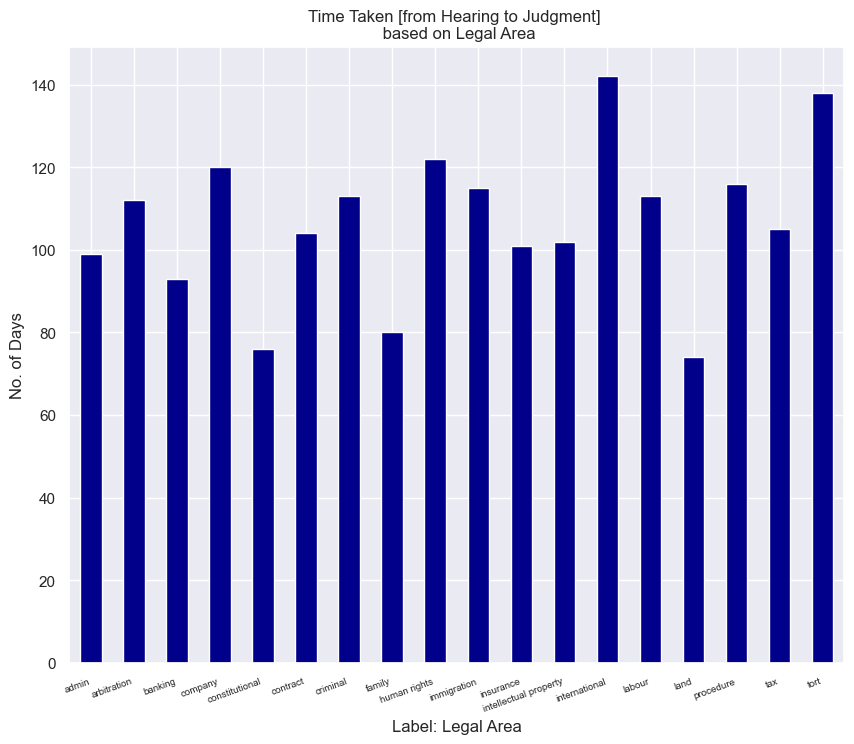

In [257]:
#how long do the UKSC take to deliver decisions in each area
plt.figure(figsize=(10,8))
sns.set(style="darkgrid")

label_decision1.plot(kind="bar", stacked=True, color=["darkblue"])

plt.xlabel('Label: Legal Area')
plt.ylabel('No. of Days')
plt.title('Time Taken [from Hearing to Judgment] \n based on Legal Area')
plt.xticks(rotation=20, ha='right', fontsize=7)

plt.savefig("H_J_Legal_Area")

In [140]:
label_decision = case_vol2.groupby(["label", "Final_Decision"])["H_Jdays"].mean()
label_decision

label                     Final_Decision
admin                     allow              93.923077
                          dismiss           101.619048
arbitration               allow             109.500000
                          dismiss           118.000000
banking                   allow              93.000000
civil                     allow             195.000000
                          dismiss            62.000000
company                   allow             114.052632
                          dismiss           124.700000
competition               allow              76.500000
constitutional            allow             102.250000
                          dismiss            42.000000
consumer protection       dismiss            62.000000
contempt                  dismiss            63.000000
contract                  allow             100.363636
                          dismiss           107.555556
criminal                  allow             113.615385
                        

In [192]:
#because the labels with less cases are skewing the data, labels with
#less than 4 cases are dropped

dropped_labels = ["legal aid", "telecom", "private", "consumer protection",
                  "contempt", "statutory interpretation", "public", "medical",
                  "public health", "fraud", "fishing", "jurisdiction",
                  "mental health", "civil", "competition", "trust", " banking"
                  "arbitration", "security", "damages", "equity", "mental capacity",
                 "shipping", "constitutional", "medical ", "banking ", " banking "]

label_decision_new = case_vol2[~case_vol2['label'].isin(dropped_labels)]

In [193]:
#check the necessary labels have been dropped
label_decision2 = label_decision_new.groupby(["label", "Final_Decision"])["H_Jdays"].mean()
label_decision2

label                  Final_Decision
admin                  allow              93.923077
                       dismiss           101.619048
arbitration            allow             109.500000
                       dismiss           118.000000
banking                allow              93.000000
company                allow             114.052632
                       dismiss           124.700000
contract               allow             100.363636
                       dismiss           107.555556
criminal               allow             113.615385
                       dismiss           112.052632
family                 allow              69.181818
                       dismiss           125.200000
human rights           allow             106.480000
                       dismiss           133.371429
immigration            allow             108.400000
                       dismiss           120.000000
insurance              allow              97.000000
                       dis

In [159]:
#to plot the data, convert to a df unstacked
label_plot = pd.DataFrame(label_decision2)
label_pivot = label_plot.pivot_table(index="label", columns="Final_Decision")

<Figure size 1000x5000 with 0 Axes>

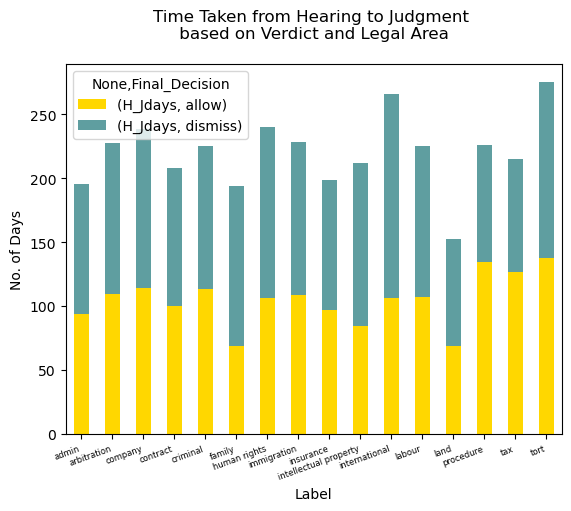

In [228]:
#trends in how decisions are made?
#without banking!

label_pivot_filtered = label_pivot[~label_pivot.index.isin(['banking'])]

plt.figure(figsize=(10,50))

label_pivot_filtered.plot(kind="bar", stacked=True, color=["gold", "cadetblue"])

plt.xlabel('Label')
plt.ylabel('No. of Days')
plt.title('Time Taken from Hearing to Judgment \n based on Verdict and Legal Area \n')
plt.xticks(rotation=20, ha='right', fontsize=6)

plt.savefig("H-J_based_on_Labels_BAR.png")

<Figure size 1500x600 with 0 Axes>

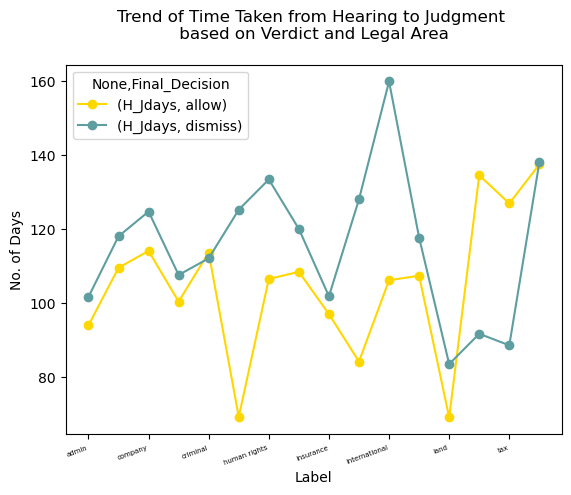

In [229]:
plt.figure(figsize=(15,6))

#decision_trends = decisions.groupby(["Year (judgment)", "Final_Decision"]).size().unstack()

label_pivot_filtered.plot(kind="line", marker="o", color=["gold", "cadetblue"])

plt.xlabel("Label")
plt.ylabel("No. of Days")
plt.title('Trend of Time Taken from Hearing to Judgment \n based on Verdict and Legal Area \n')
plt.xticks(rotation=20, ha='right',fontsize=5)

plt.savefig("H-J_based_on_Labels_LINE.png")